# 0 - Introdução

## Análise Crítica do Problema e Dados

### Impacto na Indústria
O projeto trata da detecção automatizada de falhas em chapas de aço, um problema de alto impacto na indústria metalurgica. Uma solução eficaz pode:

- Reduzir falhas humanas na inspeção visual
- Aumentar a segurança estrutural dos produtos finais
- Minimizar custos com retrabalho, devoluções e desperdícios

### Qualidade dos Dados
Os dados fornecidos refletem a realidade industrial, apresentando:

- **Valores negativos** em variaveis como x_minimo, perimetro_x, etc. Possivelmente devido a medição da parte inferior da chapa (ex: sistema SIAS)
- **Hífens** em variaveis binarias (tipo_do_aço_A300, tipo_do_aço_A400)

**Tratamentos realizados**:
- Conversão e limpeza de colunas binárias
- Imputação de valores ausentes com SimpleImputer
- Mapeamento de strings para valores binários
- Conversão da estrutura multirrótulo para uma coluna classe_defeito
- Criação de features combinadas (razões, produtos, indicadores)
- Remoção de outliers com base no IQR por classe

### Interpretação dos Valores Negativos

Durante a análise exploratória, foi identificado que algumas variáveis contínuas possuem valores negativos, especialmente:

- x_minimo, x_maximo, y_minimo, y_maximo
- perimetro_x, perimetro_y
- indice_de_variacao_x, log_indice_x, log_indice_y

A princípio, valores negativos em variáveis como coordenadas ou perímetros podem parecer erros de medição. No entanto, no contexto da indústria siderúrgica, especialmente com sistemas automatizados como o SIAS (Sistema de Inspeção Automática de Superfícies), esse comportamento pode ser intencional e informativo.

#### Possível Justificativa:
Os sistemas de inspeção como o SIAS escaneiam a chapa por cima e por baixo, gerando registros separados para cada face. Quando um defeito é detectado:

- O sistema pode atribuir valores negativos as coordenadas ou medidas relativas a face inferior da chapa, para diferenciá-las da superior.
- Isso permite manter um mesmo sistema de coordenadas, mas distinguindo a origem do defeito (superior ou inferior) de forma embutida.

#### Decisão de análise:
- Em vez de eliminar ou substituir os negativos, optei por manter esses valores no dataset, considerando que eles carregam significado físico ou de posicionamento.
- Também foi feita uma análise da associação entre o sinal (positivo/negativo) e a ocorrência de cada tipo de falha, buscando identificar padrões.

### Tipo de Modelagem
Apesar do dataset original apresentar múltiplas colunas binarias (falha_1 a falha_outros), cada instância possui apenas uma falha verdadeira. Por isso, o problema foi reformulado como uma **classificação multiclasse**, utilizando uma nova variável chamada classe_defeito.

**Motivações**:

- Simplicidade de modelagem e interpretação
- Compatibilidade com bibliotecas como XGBoost
- Avaliação mais direta com métricas padrão

### Modelo Utilizado
O modelo é o XGBoostClassifier, dentro de um pipeline integrado com:

- Pré-processamento via ColumnTransformer (numérico + categórico)
- Balanceamento com SMOTE para lidar com classes minoritárias
- Hiperparâmetros otimizados (ex: max_depth, learning_rate, reg_alpha, etc.)

Essa combinação melhora a capacidade de generalização mesmo em cenários desbalanceados e com ruído.

### Métricas de Avaliação
As métricas principais utilizadas foram:

- **F1-Score por classe** (micro análise)
- **F1-Macro** (macro análise, ideal para classes desbalanceadas)
- **Confusion Matrix** (visualização dos erros e acertos)

O modelo foi validado com validação cruzada (cross_val_score, 5 folds) usando f1_macro, garantindo robustez na avaliação.

### Desbalanceamento de Classes
Houve **forte desbalanceamento** nas classes de falha:

- falha_outros e falha_6: muito mais frequentes
- falha_5, falha_1, falha_4: com pouquíssimas amostras

### Desbalanceamento de Classes
O dataset apresenta forte desbalanceamento:

- Classes como falha_5 e falha_4 são muito raras
- falha_outros é altamente dominante

**Soluções adotadas**:
- Aplicação de SMOTE no conjunto de treino
- Tuning de hiperparâmetros no XGBoost
- Avaliação por métricas robustas como F1-Macro

---

### Conclusão
O EDA revelou um conjunto de dados desafiador e realista, com características típicas de ambientes industriais. A modelagem com XGBoost, aliada ao tratamento adequado dos dados e escolha criteriosa de métricas, permitiu obter uma solução robusta e aplicável no contexto real de inspeção de qualidade de chapas de aço.


# 1 - Obtendo os Dados

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [78]:
df = pd.read_csv('C:/Users/natha/Downloads/RES_IA/data/bootcamp_train.csv')

In [79]:
df.shape # Número de linhas e colunas

(3390, 39)

In [80]:
# As falhas parecem ter valores diferentes entre elas
# Verificar as colunas: tipo_do_aço_A300 e tipo_do_aço_A400
df.dtypes

id                                int64
x_minimo                          int64
x_maximo                        float64
y_minimo                          int64
y_maximo                          int64
peso_da_placa                     int64
area_pixels                       int64
perimetro_x                       int64
perimetro_y                       int64
soma_da_luminosidade            float64
maximo_da_luminosidade          float64
comprimento_do_transportador      int64
tipo_do_aço_A300                 object
tipo_do_aço_A400                 object
espessura_da_chapa_de_aço       float64
temperatura                     float64
index_de_bordas                 float64
index_vazio                     float64
index_quadrado                  float64
index_externo_x                 float64
indice_de_bordas_x              float64
indice_de_bordas_y              float64
indice_de_variacao_x            float64
indice_de_variacao_y            float64
indice_global_externo           float64


In [81]:
df.head()

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,tipo_do_aço_A300,tipo_do_aço_A400,espessura_da_chapa_de_aço,temperatura,index_de_bordas,index_vazio,index_quadrado,index_externo_x,indice_de_bordas_x,indice_de_bordas_y,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros
0,0,154,169.0,260124,260136,100,75,27,17,9948.0,143.0,1364,Não,sim,40.0,80.799570,0.2258,0.5833,0.8000,0.0110,0.5556,0.7059,0.149014,0.149014,0.0,1.8751,1.1761,1.0792,-0.2000,0.0362,0.3068,125,False,0,False,False,não,False,Sim
1,1,1121,-186.0,1789332,1789337,100,-206,9,-194,2240.0,150.0,-214,Não,sim,50.0,79.790721,0.3412,0.5143,0.7143,0.0052,0.7778,0.8333,-0.041479,-0.041479,0.0,1.2305,0.8451,0.6990,-0.2857,0.0294,0.1441,115,False,False,False,True,Não,False,Não
2,2,41,216.0,2708878,2708939,100,6298,275,134,654634.0,126.0,1358,não,sim,40.0,80.871970,0.0604,0.4100,0.3486,0.1289,0.6364,0.4552,-0.089962,-0.054972,0.0,3.7992,2.2430,1.7853,-0.6514,-0.1879,1.0000,42,False,False,True,False,não,False,Não
3,3,129,157.0,86408,86427,100,276,39,26,33858.0,135.0,1362,Não,Sim,40.0,77.482247,0.1894,0.4812,0.6786,0.0206,0.7179,0.7308,0.254686,0.451035,0.0,2.4409,1.4472,1.2787,-0.3214,-0.0416,0.8223,115,False,False,True,False,não,False,Não
4,4,436,442.0,4959398,530985,100,63,17,17,6374.0,116.0,1356,1,Não,70.0,73.854550,0.6431,0.3823,0.3529,0.0044,0.3529,1.0000,0.929754,-0.070246,1.0,1.7993,0.7782,1.2305,0.6471,-0.2096,0.2083,90,False,True,False,False,Não,False,Não


#2 - Tratamentos

## 2.1 - Tratando colunas nulas

In [82]:
df.isnull().sum() # Verificando os nulos

id                                0
x_minimo                          0
x_maximo                         56
y_minimo                          0
y_maximo                          0
peso_da_placa                     0
area_pixels                       0
perimetro_x                       0
perimetro_y                       0
soma_da_luminosidade            100
maximo_da_luminosidade           98
comprimento_do_transportador      0
tipo_do_aço_A300                  0
tipo_do_aço_A400                 76
espessura_da_chapa_de_aço        41
temperatura                       0
index_de_bordas                   0
index_vazio                       0
index_quadrado                   36
index_externo_x                   0
indice_de_bordas_x                0
indice_de_bordas_y                0
indice_de_variacao_x              0
indice_de_variacao_y              0
indice_global_externo            59
log_das_areas                     0
log_indice_x                      0
log_indice_y                

In [83]:
df_final = df.copy() # Criando uma cópia do Dataframe, nesse não farei a imputação.
df_final.shape

(3390, 39)

In [84]:
colunas_com_nulos = [
    'x_maximo', 'soma_da_luminosidade', 'maximo_da_luminosidade', 'espessura_da_chapa_de_aço', 'index_quadrado',
    'indice_global_externo', 'indice_de_luminosidade'
]

for col in colunas_com_nulos:
    df[col] = df[col].fillna(df[col].median())

In [85]:
df.isnull().sum()

id                               0
x_minimo                         0
x_maximo                         0
y_minimo                         0
y_maximo                         0
peso_da_placa                    0
area_pixels                      0
perimetro_x                      0
perimetro_y                      0
soma_da_luminosidade             0
maximo_da_luminosidade           0
comprimento_do_transportador     0
tipo_do_aço_A300                 0
tipo_do_aço_A400                76
espessura_da_chapa_de_aço        0
temperatura                      0
index_de_bordas                  0
index_vazio                      0
index_quadrado                   0
index_externo_x                  0
indice_de_bordas_x               0
indice_de_bordas_y               0
indice_de_variacao_x             0
indice_de_variacao_y             0
indice_global_externo            0
log_das_areas                    0
log_indice_x                     0
log_indice_y                     0
indice_de_orientaçao

## 2.2 - Tratando as colunas Binárias

In [86]:
# Quantos registros têm A300 = 1 e A400 = 1? (Teroicamente, não deveria ser possível)
print("A300 = 1 e A400 = 1?",df[(df['tipo_do_aço_A300'] == 1) & (df['tipo_do_aço_A400'] == 1)].shape[0])
# Quantos registros têm A300 = 0 e A400 = 0? (Teroicamente, não deveria ser possível)
print("A300 = 0 e A400 = 0?",df[(df['tipo_do_aço_A300'] == 0) & (df['tipo_do_aço_A400'] == 0)].shape[0])

A300 = 1 e A400 = 1? 0
A300 = 0 e A400 = 0? 0


In [87]:
print("Valores únicos em tipo_do_aço_A300:", df['tipo_do_aço_A300'].unique())
print("Valores únicos em tipo_do_aço_A400:", df['tipo_do_aço_A400'].unique())

Valores únicos em tipo_do_aço_A300: ['Não' 'não' '1' 'Sim' 'sim' '0' 'N' '-']
Valores únicos em tipo_do_aço_A400: ['sim' 'Sim' 'Não' 'não' nan '1' '0' 'S' 'nao']


In [88]:
df[(df['tipo_do_aço_A300'] == '-') | (df['tipo_do_aço_A400'] == '-')] # Verificando se o - tem um valor fixo

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,tipo_do_aço_A300,tipo_do_aço_A400,espessura_da_chapa_de_aço,temperatura,index_de_bordas,index_vazio,index_quadrado,index_externo_x,indice_de_bordas_x,indice_de_bordas_y,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros
403,403,1213,-186.0,1962342,1962347,100,16,-229,6,2076.0,127.0,-214,-,Sim,50.0,87.814274,0.2047,0.4667,0.8333,0.0044,0.6667,0.8333,0.014094,0.014094,0.0,1.2041,0.7782,0.6990,-0.1667,0.0137,0.1400,1119,0,False,False,True,Não,False,Não
1489,1489,68,103.0,149046,149092,100,521,90,54,62926.0,135.0,1354,-,não,70.0,73.604542,0.1004,0.6764,0.7609,0.0258,0.3889,0.8518,1.378775,0.378775,1.0,2.7168,1.5441,1.6628,0.2391,-0.0564,0.9998,104,False,True,False,False,não,False,Não
1745,1745,1073,-186.0,2426501,-166,100,196,35,29,24783.0,140.0,1356,-,Sim,40.0,91.450322,0.4254,0.4444,0.8947,0.0176,0.6154,0.7188,0.071511,1.071511,1.0,2.2923,1.3802,1.3222,0.1053,0.0021,0.7933,119,False,False,True,False,não,False,Não
2387,2387,1065,1071.0,1204128,-166,100,-206,10,12,2587.0,149.0,1687,-,Não,143.0,99.266584,0.4938,0.2083,0.9167,0.0037,1.0000,1.0000,-0.277270,-0.277270,0.0,1.8451,1.0414,1.0792,-0.0833,0.0317,0.2432,120,False,False,False,False,não,True,Não
3000,3000,41,54.0,-20,1508040,100,131,20,22,13148.0,95.0,1358,-,Sim,40.0,72.423751,0.0604,0.2663,0.5454,0.0088,0.5500,1.0000,-0.572342,-0.572342,1.0,2.1173,1.0792,1.3424,0.4545,-0.4545,0.4366,45,True,False,False,False,Não,False,Não
3185,3185,15,24.0,1636571,1636729,100,205,21,20,21545.0,124.0,1354,-,Sim,50.0,72.938278,0.0354,0.3222,0.3500,0.0110,0.6429,1.0000,0.399172,0.399172,1.0,2.3201,1.1761,1.3010,0.6500,-0.1300,0.4630,92,False,0,False,False,não,True,Não


In [89]:
df['tipo_do_aço_A300'] = df['tipo_do_aço_A300'].astype(str).str.strip().str.lower()
df['tipo_do_aço_A400'] = df['tipo_do_aço_A400'].astype(str).str.strip().str.lower()

# Corrigindo os hifens com base na logica de exclusão mutua
df.loc[df['tipo_do_aço_A300'] == '-', 'tipo_do_aço_A300'] = df['tipo_do_aço_A400'].map({'sim': 'não', 'não': 'sim'})
df.loc[df['tipo_do_aço_A400'] == '-', 'tipo_do_aço_A400'] = df['tipo_do_aço_A300'].map({'sim': 'não', 'não': 'sim'})

In [90]:
#Mapeando os diferentes valores binários
mapa_binario = {
    '1': 1, 'sim': 1, 'true': 1, 's': 1, 'y': 1, 'S': 1, 'Sim': 1, True: 1,
    '0': 0, 'não': 0, 'nao': 0, 'false': 0, 'n': 0, 'Não': 0, False: 0
}

# Listando as minhas colunas binárias
colunas_binarias = [
    'tipo_do_aço_A300', 'tipo_do_aço_A400',
    'falha_1', 'falha_2', 'falha_4', 'falha_5', 'falha_outros'
]

# Para cada coluna binaria irei converter pra string, remover espaços, colocar em minusculo e aplicar o mapeamento
for col in colunas_binarias:
    df[col] = df[col].astype(str).str.strip().str.lower().map(mapa_binario)

# Preencho os valores vazios de tipo de aço A400 com os opostos de A300
df.loc[df['tipo_do_aço_A400'].isna(), 'tipo_do_aço_A400'] = df['tipo_do_aço_A300'].map({1: 0, 0: 1}).astype(int)

df['falha_3'] = df['falha_3'].astype(int)
df['falha_6'] = df['falha_6'].astype(int)

In [91]:
# Quantos registros têm A300 = 1 e A400 = 1? (Teroicamente, não deveria ser possível)
print("A300 = 1 e A400 = 1?",df[(df['tipo_do_aço_A300'] == 1) & (df['tipo_do_aço_A400'] == 1)].shape[0])
# Quantos registros têm A300 = 0 e A400 = 0? (Teroicamente, não deveria ser possível)
print("A300 = 0 e A400 = 0?",df[(df['tipo_do_aço_A300'] == 0) & (df['tipo_do_aço_A400'] == 0)].shape[0])

A300 = 1 e A400 = 1? 0
A300 = 0 e A400 = 0? 1


In [92]:
df[(df['tipo_do_aço_A300'] == 0) & (df['tipo_do_aço_A400'] == 0)] # Único registro com dois valores iguais, consultando o dataframe original

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,tipo_do_aço_A300,tipo_do_aço_A400,espessura_da_chapa_de_aço,temperatura,index_de_bordas,index_vazio,index_quadrado,index_externo_x,indice_de_bordas_x,indice_de_bordas_y,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros
3068,3068,39,214.0,1704638,1704636,100,5695,278,155,541466.0,124.0,1356,0,0.0,40.0,68.983954,0.0575,0.4563,0.5355,0.1289,0.6627,0.5185,0.067579,1.067579,0.0,3.7863,2.243,1.716,-0.4645,-0.1879,1.0,37,0,0,1,0,0,0,0


In [93]:
df_final[(df_final['id'] == 3068)] # Único registro com dois valores iguais, consultando o dataframe original

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,tipo_do_aço_A300,tipo_do_aço_A400,espessura_da_chapa_de_aço,temperatura,index_de_bordas,index_vazio,index_quadrado,index_externo_x,indice_de_bordas_x,indice_de_bordas_y,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros
3068,3068,39,214.0,1704638,1704636,100,5695,278,155,541466.0,124.0,1356,Não,Não,40.0,68.983954,0.0575,0.4563,0.5355,0.1289,0.6627,0.5185,0.067579,1.067579,0.0,3.7863,2.243,1.716,-0.4645,-0.1879,1.0,37,False,False,True,0,não,False,Não


In [94]:
df = df[~((df['tipo_do_aço_A300'] == 0) & (df['tipo_do_aço_A400'] == 0))]
df.shape

(3389, 39)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3389 entries, 0 to 3389
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3389 non-null   int64  
 1   x_minimo                      3389 non-null   int64  
 2   x_maximo                      3389 non-null   float64
 3   y_minimo                      3389 non-null   int64  
 4   y_maximo                      3389 non-null   int64  
 5   peso_da_placa                 3389 non-null   int64  
 6   area_pixels                   3389 non-null   int64  
 7   perimetro_x                   3389 non-null   int64  
 8   perimetro_y                   3389 non-null   int64  
 9   soma_da_luminosidade          3389 non-null   float64
 10  maximo_da_luminosidade        3389 non-null   float64
 11  comprimento_do_transportador  3389 non-null   int64  
 12  tipo_do_aço_A300              3389 non-null   int64  
 13  tipo_do_

In [96]:
# Fazendo as mesmas transformações para o df_final (O que não foi inputado)
df_final['tipo_do_aço_A300'] = df_final['tipo_do_aço_A300'].astype(str).str.strip().str.lower()
df_final['tipo_do_aço_A400'] = df_final['tipo_do_aço_A400'].astype(str).str.strip().str.lower()

# Corrigir hífens com base na lógica de exclusão mútua
df_final.loc[df_final['tipo_do_aço_A300'] == '-', 'tipo_do_aço_A300'] = df_final['tipo_do_aço_A400'].map({'sim': 'não', 'não': 'sim'})
df_final.loc[df_final['tipo_do_aço_A400'] == '-', 'tipo_do_aço_A400'] = df_final['tipo_do_aço_A300'].map({'sim': 'não', 'não': 'sim'})

mapa_binario = {
    '1': 1, 'sim': 1, 'true': 1, 's': 1, 'y': 1, 'S': 1, 'Sim': 1, True: 1,
    '0': 0, 'não': 0, 'nao': 0, 'false': 0, 'n': 0, 'Não': 0, False: 0
}

colunas_binarias = [
    'tipo_do_aço_A300', 'tipo_do_aço_A400',
    'falha_1', 'falha_2', 'falha_4', 'falha_5', 'falha_outros'
]

for col in colunas_binarias:
    df_final[col] = df_final[col].astype(str).str.strip().str.lower().map(mapa_binario)

df_final['falha_3'] = df_final['falha_3'].astype(int)
df_final['falha_6'] = df_final['falha_6'].astype(int)

df_final.loc[df_final['tipo_do_aço_A400'].isna(), 'tipo_do_aço_A400'] = df_final['tipo_do_aço_A300'].map({1: 0, 0: 1}).astype(int)

df_final = df_final[~((df_final['tipo_do_aço_A300'] == 0) & (df_final['tipo_do_aço_A400'] == 0))]
df_final.shape

(3389, 39)

#2.3 - Removendo coluna constante

In [97]:
df.nunique()

id                              3389
x_minimo                        1136
x_maximo                         945
y_minimo                        2016
y_maximo                        1809
peso_da_placa                      1
area_pixels                      850
perimetro_x                      363
perimetro_y                      294
soma_da_luminosidade            1782
maximo_da_luminosidade            91
comprimento_do_transportador      83
tipo_do_aço_A300                   2
tipo_do_aço_A400                   2
espessura_da_chapa_de_aço         24
temperatura                     3389
index_de_bordas                 1347
index_vazio                     1286
index_quadrado                   744
index_externo_x                  433
indice_de_bordas_x               778
indice_de_bordas_y               618
indice_de_variacao_x            3389
indice_de_variacao_y            3389
indice_global_externo              3
log_das_areas                    862
log_indice_x                     177
l

In [98]:
df = df.drop(columns=['peso_da_placa']) #Peso da placa tem apenas um valor, por isso podemos deletar

In [99]:
df.shape

(3389, 38)

In [100]:
df_final = df_final.drop(columns=['peso_da_placa']) #Fazendo a mesma coisa no df que não foi inputado
df_final.shape

(3389, 38)

# 3 - Tentando entender os valores negativos

In [101]:
valores_negativos = (df.select_dtypes(include='number') < 0).sum()
display(valores_negativos)

id                                 0
x_minimo                         339
x_maximo                         333
y_minimo                         339
y_maximo                         339
area_pixels                      339
perimetro_x                      339
perimetro_y                      339
soma_da_luminosidade               0
maximo_da_luminosidade             0
comprimento_do_transportador     339
tipo_do_aço_A300                   0
tipo_do_aço_A400                   0
espessura_da_chapa_de_aço        338
temperatura                        0
index_de_bordas                    0
index_vazio                        0
index_quadrado                     0
index_externo_x                    0
indice_de_bordas_x                 0
indice_de_bordas_y                 0
indice_de_variacao_x            1508
indice_de_variacao_y            1293
indice_global_externo              0
log_das_areas                      0
log_indice_x                       0
log_indice_y                       0
i

<Figure size 1000x600 with 0 Axes>

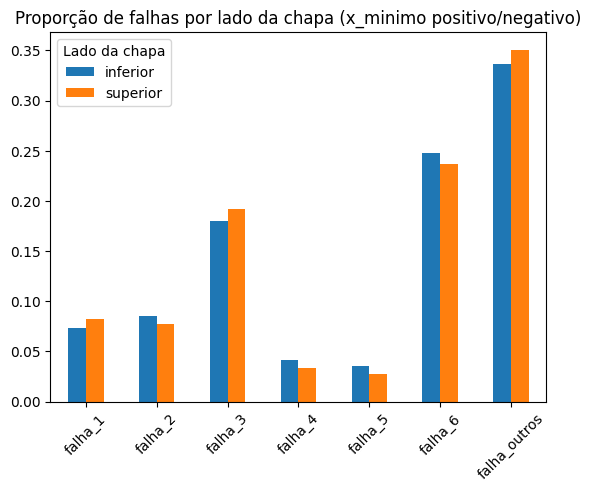

In [102]:
# Criando uma variavel indicando o lado da chapa com base em x_minimo
df['lado_chapa'] = df['x_minimo'].apply(lambda x: 'superior' if x >= 0 else 'inferior')

# Contando as falhas por lado
falhas = ['falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5', 'falha_6', 'falha_outros']
distribuicao_falhas = df.groupby('lado_chapa')[falhas].sum().T

# Normalizando pelo total de cada lado
proporcao_falhas = distribuicao_falhas.div(distribuicao_falhas.sum(axis=0), axis=1)

# Gerar gráfico
plt.figure(figsize=(10, 6))
proporcao_falhas.plot(kind='bar')
plt.title('Proporção de falhas por lado da chapa (x_minimo positivo/negativo)')
plt.xticks(rotation=45)
plt.legend(title='Lado da chapa')
plt.show()
# Falhas especificas ocorrem mais frequentemente com valores negativos, acredito que possa usar como justificativa para manter os sinais negativos.

<Axes: title={'center': 'Falhas por sinal de índice de orientação'}, xlabel='grupo_orientacao'>

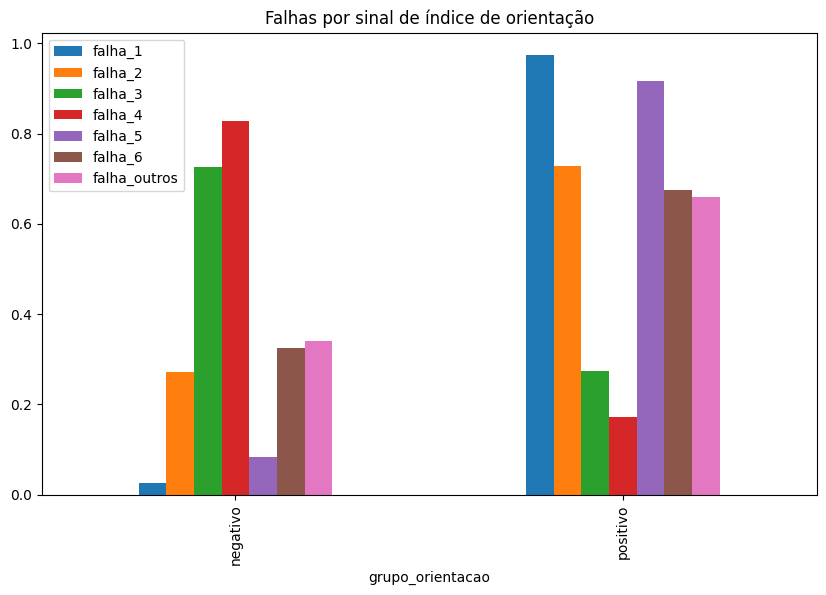

In [103]:
# Exemplo para 'indice_de_orientacao'
df['grupo_orientacao'] = df['indice_de_orientaçao'].apply(lambda x: 'positivo' if x >= 0 else 'negativo')

# Calcular proporções
grupo = df.groupby('grupo_orientacao')[falhas].sum()
proporcoes = grupo.div(grupo.sum(axis=0), axis=1)

proporcoes.plot(kind='bar', figsize=(10,6), title='Falhas por sinal de índice de orientação')
# As falhas 3 e 4 ocorrem mais vezes com sinais negativos

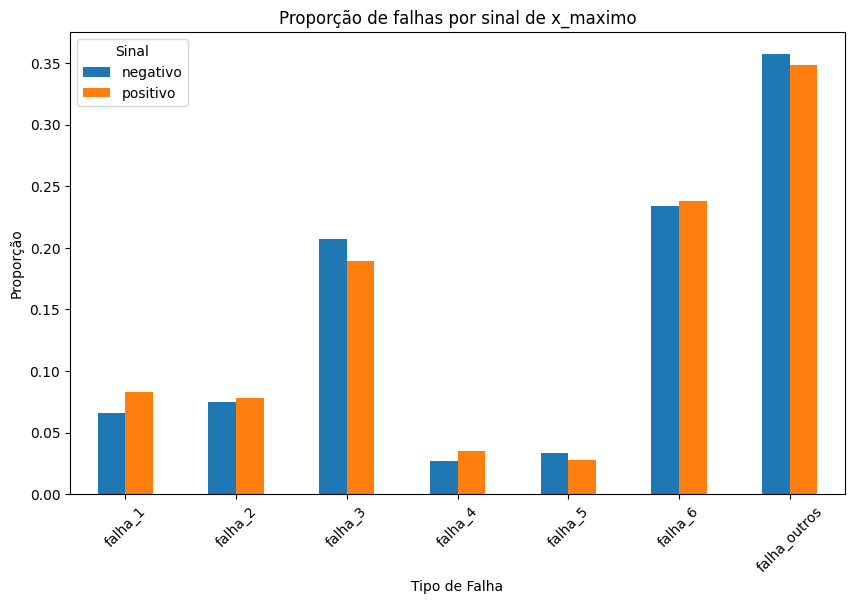

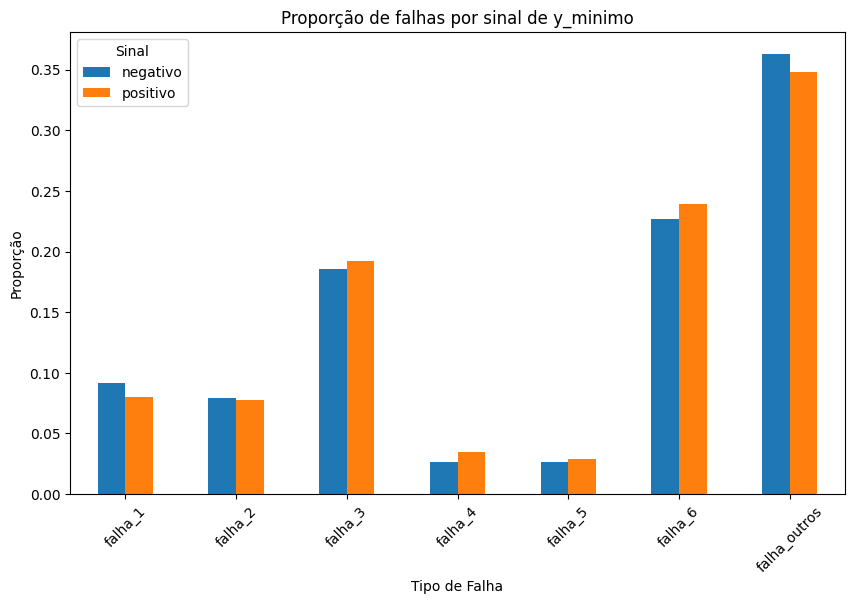

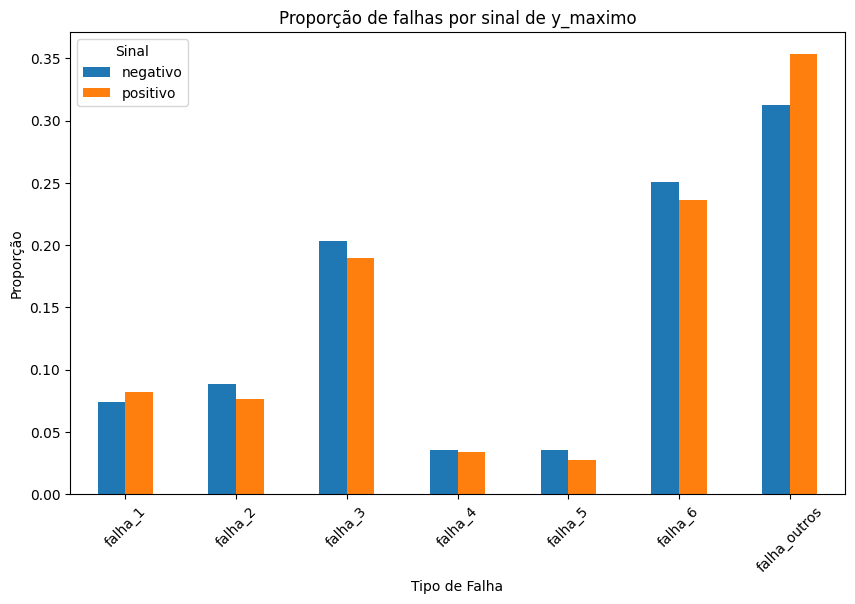

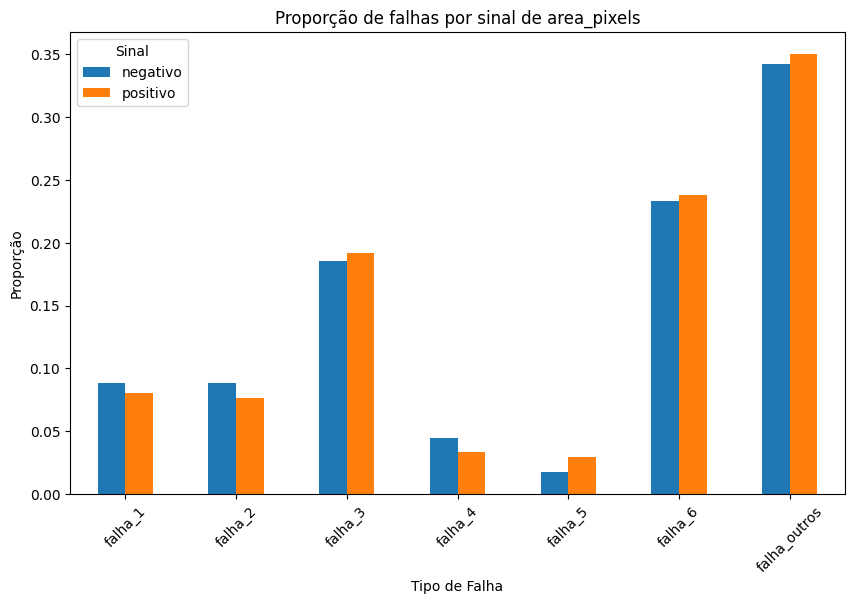

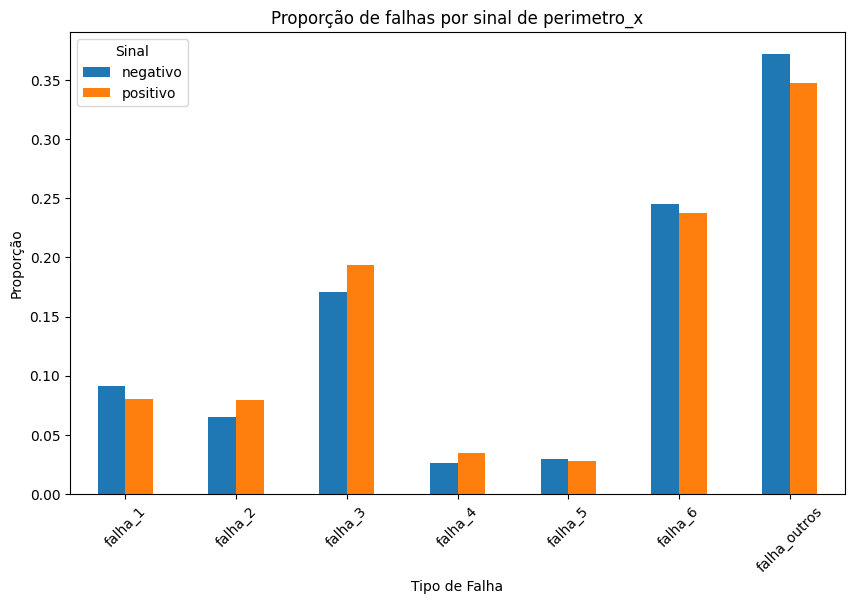

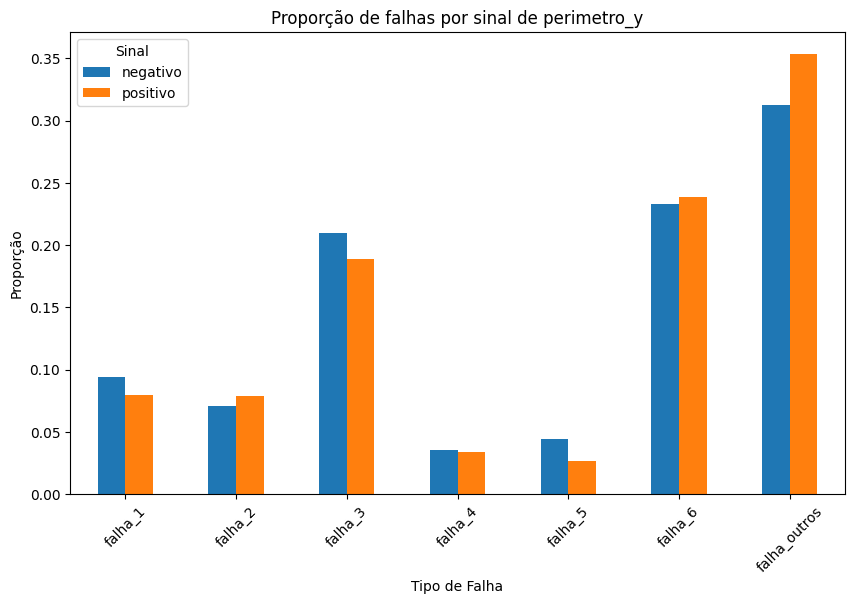

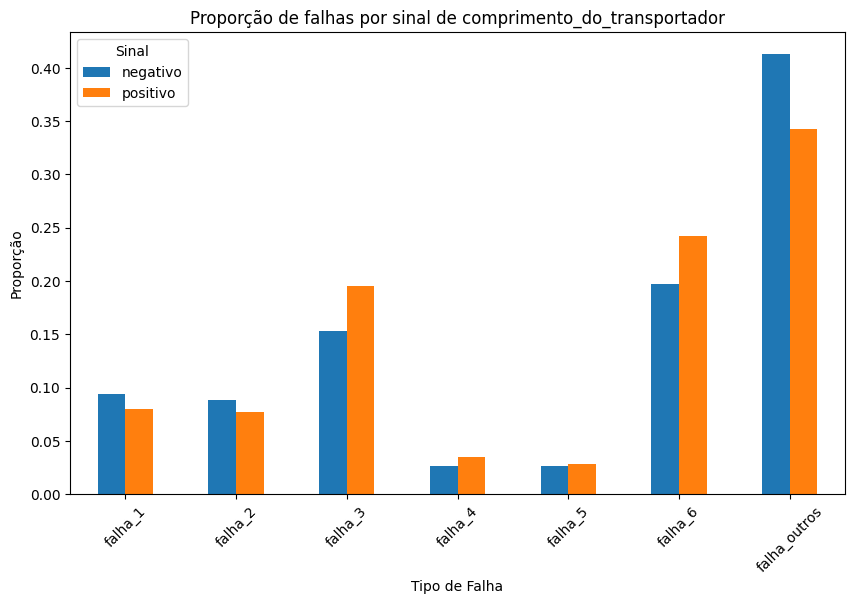

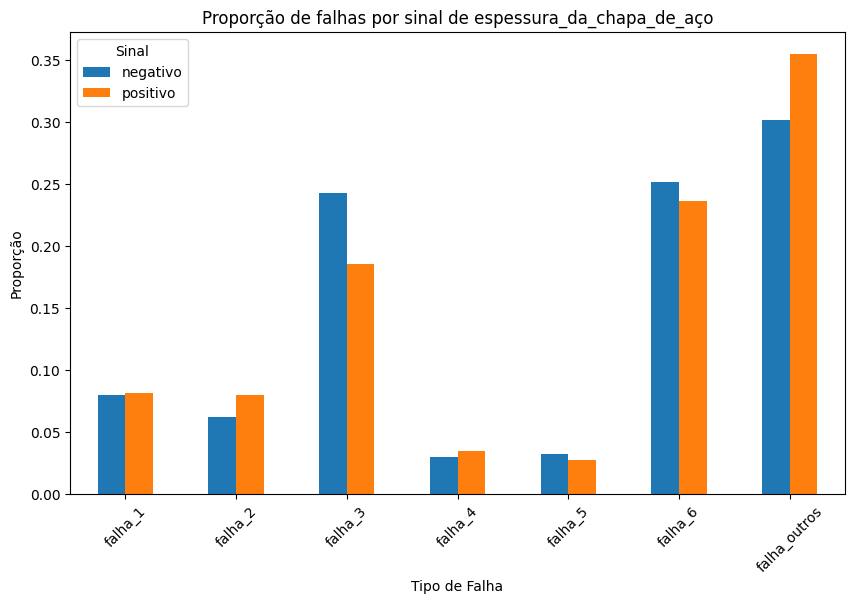

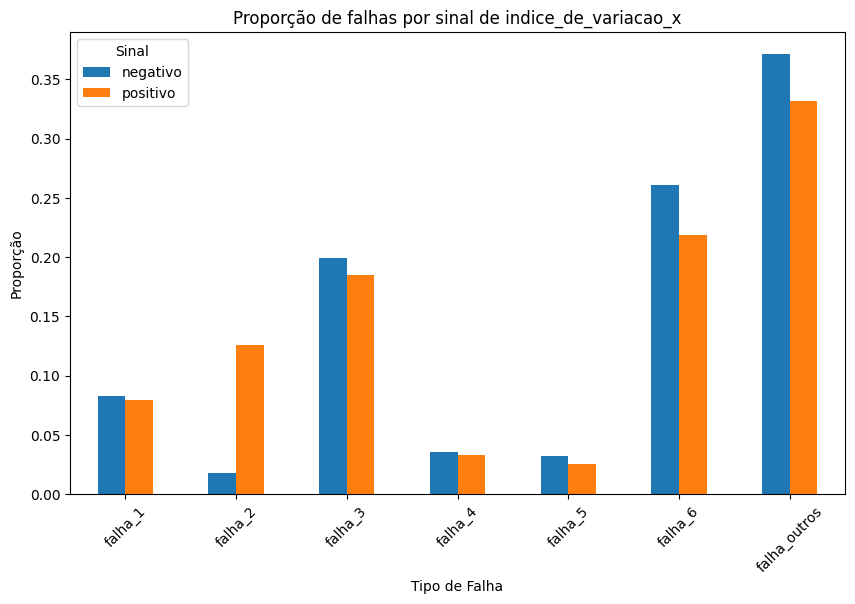

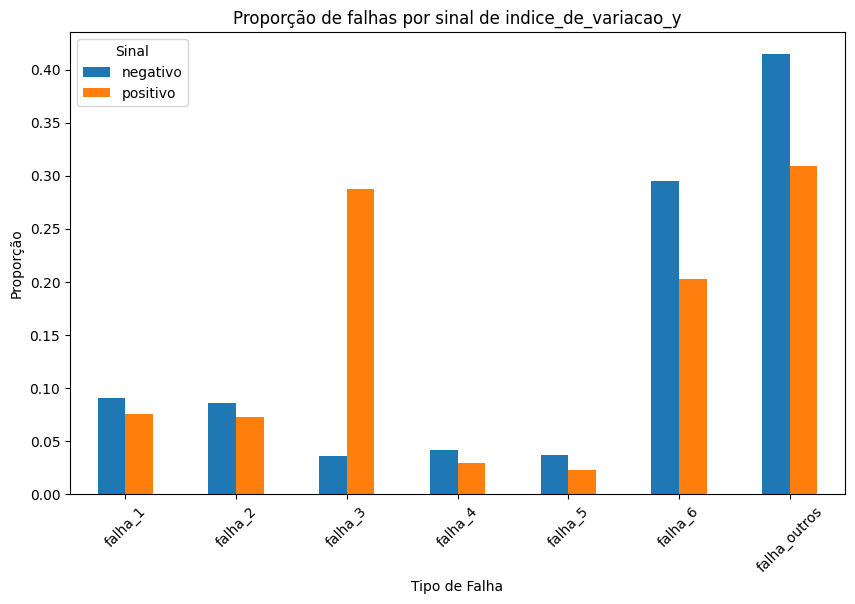

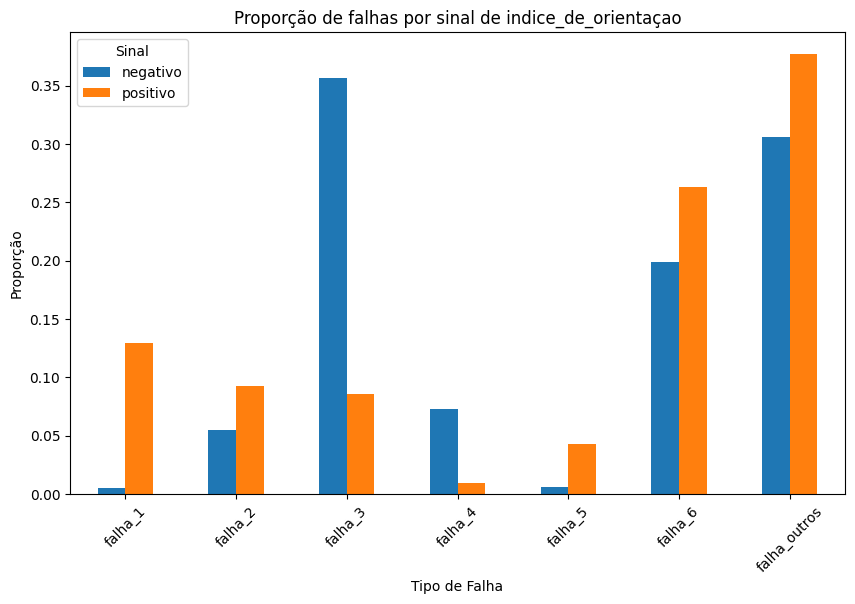

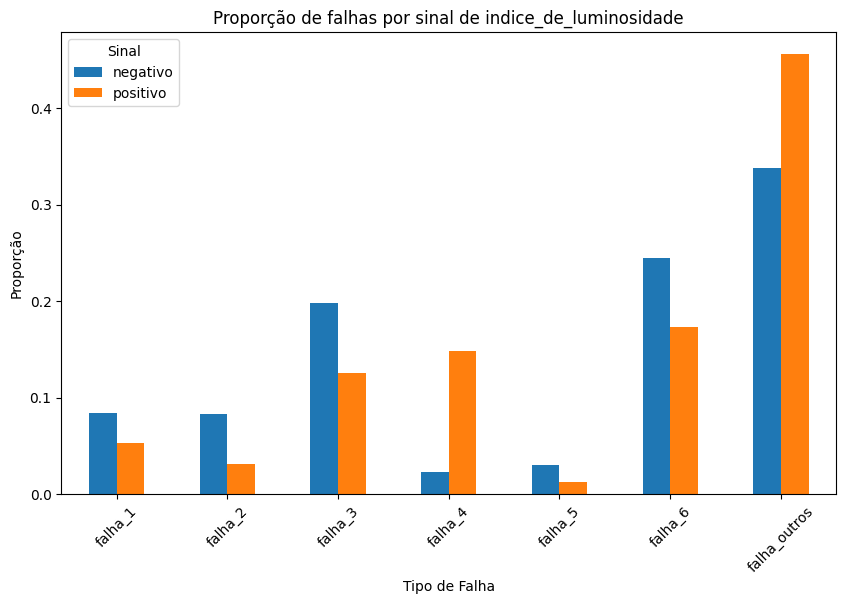

In [104]:
colunas_negativas = [
    'x_maximo', 'y_minimo', 'y_maximo', 'area_pixels',
    'perimetro_x', 'perimetro_y', 'comprimento_do_transportador',
    'espessura_da_chapa_de_aço', 'indice_de_variacao_x',
    'indice_de_variacao_y', 'indice_de_orientaçao', 'indice_de_luminosidade'
]

# Tipos de falha
falhas = ['falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5', 'falha_6', 'falha_outros']

# Gerar um gráfico para cada coluna
for coluna in colunas_negativas:
    grupo_col = f'grupo_{coluna}'
    df[grupo_col] = df[coluna].apply(lambda x: 'positivo' if x >= 0 else 'negativo')

    distribuicao = df.groupby(grupo_col)[falhas].sum().T
    proporcao = distribuicao.div(distribuicao.sum(axis=0), axis=1)

    proporcao.plot(kind='bar', figsize=(10, 6), title=f'Proporção de falhas por sinal de {coluna}')
    plt.ylabel('Proporção')
    plt.xlabel('Tipo de Falha')
    plt.xticks(rotation=45)
    plt.legend(title='Sinal')
    plt.show()
    # Por meio dessa sequência de gráficos, é possível visualizar que algumas falhas acabam acontecendo mais com os valores negativos, 
    # reforçando a ideia que tinha sobre mantê-los.

In [105]:
# Criando um dicionario para armazenar as proporções
proporcoes_dict = {}

# Recalcula as proporções de falha por sinal para cada coluna negativa
for coluna in colunas_negativas:
    grupo_col = f'grupo_{coluna}'
    df[grupo_col] = df[coluna].apply(lambda x: 'positivo' if x >= 0 else 'negativo')

    distribuicao = df.groupby(grupo_col)[falhas].sum().T
    proporcao = distribuicao.div(distribuicao.sum(axis=0), axis=1)

    # Armazenar resultado
    proporcoes_dict[coluna] = proporcao

# Concatenar os resultados em um único dataframe multi-indexado
df_proporcoes = pd.concat(proporcoes_dict, axis=1)

# Reorganizar para melhor visualização
df_proporcoes.columns.names = ['Variável', 'Sinal']
df_proporcoes_percent = (df_proporcoes * 100).round(2).astype(str) + '%'
display(df_proporcoes_percent)

Variável     x_maximo          y_minimo          y_maximo           \
Sinal        negativo positivo negativo positivo negativo positivo   
falha_1         6.61%    8.28%    9.14%     8.0%    7.37%     8.2%   
falha_2         7.51%    7.82%    7.96%    7.77%    8.85%    7.67%   
falha_3        20.72%   18.95%   18.58%   19.18%   20.35%   18.98%   
falha_4          2.7%     3.5%    2.65%    3.51%    3.54%    3.41%   
falha_5          3.3%    2.78%    2.65%    2.85%    3.54%    2.75%   
falha_6        23.42%   23.82%   22.71%    23.9%   25.07%   23.64%   
falha_outros   35.74%   34.85%   36.28%   34.79%   31.27%   35.34%   

Variável     area_pixels          perimetro_x          perimetro_y           \
Sinal           negativo positivo    negativo positivo    negativo positivo   
falha_1            8.85%    8.03%       9.14%     8.0%       9.44%    7.97%   
falha_2            8.85%    7.67%       6.49%    7.93%       7.08%    7.87%   
falha_3           18.58%   19.18%      17.11%   19.34%      20.94%   18.92%   
falha_4            4.42%    3.31%       2.65%    3.51%       3.54%    3.41%   
falha_5            1.77%    2.95%       2.95%    2.82%       4.42%    2.66%   
falha_6            23.3%   23.84%      24.48%    23.7%       23.3%   23.84%   
falha_outros      34.22%   35.02%      37.17%   34.69%      31.27%   35.34%   

Variável     comprimento_do_transportador          espessura_da_chapa_de_aço  \
Sinal                            negativo positivo                  negativo   
falha_1                             9.44%    7.97%                     7.99%   
falha_2                             8.85%    7.67%                     6.21%   
falha_3                            15.34%   19.54%                    24.26%   
falha_4                             2.65%    3.51%                     2.96%   
falha_5                             2.65%    2.85%                     3.25%   
falha_6                            19.76%   24.23%                    25.15%   
falha_outros                        41.3%   34.23%                    30.18%   

Variável              indice_de_variacao_x          indice_de_variacao_y  \
Sinal        positivo             negativo positivo             negativo   
falha_1         8.13%                8.29%    7.97%                9.05%   
falha_2         7.96%                1.79%    12.6%                8.58%   
falha_3        18.55%               19.89%    18.5%                3.56%   
falha_4         3.47%                3.58%     3.3%                4.18%   
falha_5         2.79%                3.18%    2.55%                3.71%   
falha_6        23.63%               26.13%    21.9%               29.47%   
falha_outros   35.46%               37.14%   33.17%               41.45%   

Variável              indice_de_orientaçao          indice_de_luminosidade  \
Sinal        positivo             negativo positivo               negativo   
falha_1         7.54%                0.53%   12.95%                   8.4%   
falha_2          7.3%                5.45%    9.28%                  8.27%   
falha_3        28.72%               35.68%    8.55%                  19.8%   
falha_4         2.96%                7.27%    0.97%                  2.25%   
falha_5         2.29%                0.61%    4.25%                   3.0%   
falha_6        20.28%               19.85%   26.29%                 24.45%   
falha_outros   30.92%               30.61%    37.7%                 33.83%   

Variável               
Sinal        positivo  
falha_1         5.35%  
falha_2         3.14%  
falha_3        12.58%  
falha_4        14.78%  
falha_5         1.26%  
falha_6         17.3%  
falha_outros    45.6%

# 4 - EDA

In [106]:
# Criando uma lista com os nomes de todas as colunas do df que começam com falha
colunas_falha = [col for col in df.columns if col.startswith('falha_')]
# Criando a coluna classe defeito, atribuindo a cada linha o nome da coluna de falha
df['classe_defeito'] = df[colunas_falha].idxmax(axis=1)

In [107]:
# Criando uma lista com os nomes de todas as colunas do df que começam com falha
# Estou fazendo isso pq esse é o dataframe em que não fiz a imputação da mediana para evitar data leakage
colunas_falha = [col for col in df_final.columns if col.startswith('falha_')]
# Criando a coluna classe defeito, atribuindo a cada linha o nome da coluna de falha
df_final['classe_defeito'] = df_final[colunas_falha].idxmax(axis=1)

In [108]:
# Verificando a proporção das classes
# Mais de 70% dos dados estão concentrados em: falhas_outros, falha_6 e falha_3
df['classe_defeito'].value_counts(normalize=True)*100

classe_defeito
falha_outros    34.936559
falha_6         23.782827
falha_3         19.120685
falha_1          8.114488
falha_2          7.789909
falha_4          3.422839
falha_5          2.832694
Name: proportion, dtype: float64

In [109]:
df['soma_defeitos'] = df[colunas_falha].sum(axis=1)
df['soma_defeitos'].value_counts()
# Existem 3389 amostras no seu DataFrame com exatamente 1 falha registrada.
# Acredito que o problema possa ser tratado como uma classificação multiclasse

soma_defeitos
1    3389
Name: count, dtype: int64

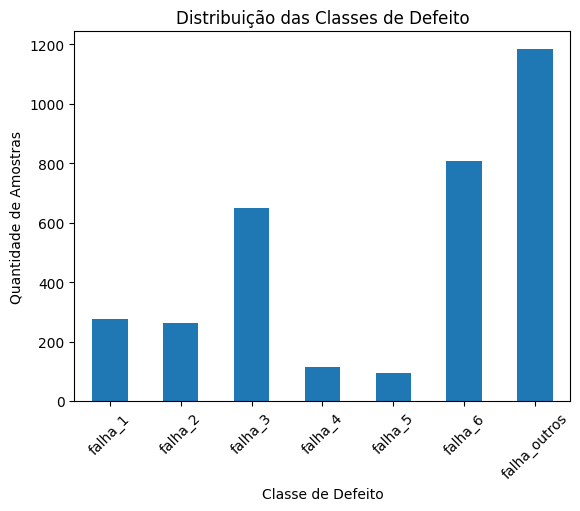

In [110]:
df['classe_defeito'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribuição das Classes de Defeito")
plt.xlabel("Classe de Defeito")
plt.ylabel("Quantidade de Amostras")
plt.xticks(rotation=45)
plt.show()
# Visual com a distribuição das classes

## 4.1 - Resumo estatistico

In [111]:
resumo_estatistico = df.describe()
display(resumo_estatistico)
# soma_defeitos com 1 em 100% das amostras, reforçando a classificação multiclasse
# algumas colunas com valores negativos, mas já foram avaliadas anteriormente
# tipo de aço são binárias

,id,x_minimo,x_maximo,y_minimo,y_maximo,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,tipo_do_aço_A300,tipo_do_aço_A400,espessura_da_chapa_de_aço,temperatura,index_de_bordas,index_vazio,index_quadrado,index_externo_x,indice_de_bordas_x,indice_de_bordas_y,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros,soma_defeitos
count,3389.000000,3389.000000,3389.000000,3.389000e+03,3.389000e+03,3389.000000,3389.000000,3389.000000,3.389000e+03,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.00000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.0
mean,1694.094718,995.789613,604.992918,2.692931e+06,1.592268e+06,1565.099439,66.671585,47.229271,1.878333e+05,129.125701,1293.153143,0.403659,0.596341,53.217468,79.927988,0.340795,0.40994,0.571796,0.031977,0.610739,0.828377,0.083135,0.192295,0.596341,2.475957,1.317482,1.395204,0.099320,-0.135027,0.570236,171.803187,0.081145,0.077899,0.191207,0.034228,0.028327,0.237828,0.349366,1.0
std,978.612930,1796.927691,543.626157,5.626497e+06,1.821613e+06,4337.744006,195.087123,336.839246,4.492389e+05,15.882208,521.184903,0.490703,0.490703,84.793740,10.000052,0.307044,0.13338,0.262420,0.053962,0.230963,0.225662,0.381359,0.473602,0.479446,0.772298,0.479028,0.429170,0.492289,0.132207,0.335362,272.982538,0.273098,0.268052,0.393310,0.181842,0.165930,0.425816,0.476840,0.0
min,0.000000,-11.000000,-186.000000,-2.000000e+01,-1.660000e+02,-206.000000,-229.000000,-194.000000,2.550000e+02,37.000000,-214.000000,0.000000,0.000000,-154.000000,45.801848,0.000000,0.00000,0.008300,0.001500,0.014400,0.048400,-0.905854,-1.218085,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.860300,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,847.000000,41.000000,181.000000,3.934280e+05,3.405980e+05,68.000000,12.000000,11.000000,9.714000e+03,124.000000,1356.000000,0.000000,0.000000,40.000000,73.138794,0.060400,0.31310,0.371400,0.006600,0.434800,0.642900,-0.165667,-0.136836,0.000000,1.929400,1.000000,1.079200,-0.285700,-0.193300,0.248200,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,1694.000000,614.000000,544.000000,1.264388e+06,1.126680e+06,142.000000,22.000000,21.000000,1.783600e+04,127.000000,1362.000000,0.000000,1.000000,60.000000,79.786282,0.232400,0.40950,0.545400,0.009500,0.636400,0.964300,0.047416,0.115595,1.000000,2.225300,1.146100,1.322200,0.111100,-0.140800,0.471300,93.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,2541.000000,1188.000000,1088.000000,2.555025e+06,2.184752e+06,521.000000,58.000000,56.000000,6.292600e+04,135.000000,1634.000000,1.000000,1.000000,80.000000,86.595048,0.621700,0.49600,0.818200,0.021200,0.789500,1.000000,0.263209,0.445235,1.000000,2.826700,1.477100,1.724300,0.526300,-0.079700,0.999300,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
max,3389.000000,15266.000000,1713.000000,1.041366e+08,1.291709e+07,152655.000000,1275.000000,18152.000000,1.159141e+07,253.000000,1794.000000,1.000000,1.000000,300.000000,121.478951,0.995200,0.94390,1.000000,0.875900,1.000000,1.000000,2.155819,1.941325,1.000000,5.183700,3.074100,4.258700,0.991700,0.591700,1.000000,2086.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [112]:
# Selecionando colunas que julgo serem interessantes
colunas_resumo = [
    'x_minimo', 'x_maximo', 'y_minimo', 'y_maximo',
    'area_pixels', 'perimetro_x', 'perimetro_y',
    'espessura_da_chapa_de_aço', 'comprimento_do_transportador',
    'temperatura', 'indice_de_orientaçao', 'indice_de_luminosidade',
    'indice_de_variacao_x', 'indice_de_variacao_y'
]

# Calculando um resumo estatistico
resumo_estatistico = df[colunas_resumo].describe().loc[['min', 'max', 'mean', 'std']].round(2)
display(resumo_estatistico)
# Trazendo o resumo estatistico das colunas que são relevantes do ponto de vista estatistico
# Os valores negativos foram mantidos, pois correspondem a inspeção de lados diferentes da chapa, uma prática comum com sistemas industriais como o SIAS

,x_minimo,x_maximo,y_minimo,y_maximo,area_pixels,perimetro_x,perimetro_y,espessura_da_chapa_de_aço,comprimento_do_transportador,temperatura,indice_de_orientaçao,indice_de_luminosidade,indice_de_variacao_x,indice_de_variacao_y
min,-11.00,-186.00,-2.000000e+01,-166.00,-206.00,-229.00,-194.00,-154.00,-214.00,45.80,-0.99,-0.86,-0.91,-1.22
max,15266.00,1713.00,1.041366e+08,12917094.00,152655.00,1275.00,18152.00,300.00,1794.00,121.48,0.99,0.59,2.16,1.94
mean,995.79,604.99,2.692931e+06,1592268.25,1565.10,66.67,47.23,53.22,1293.15,79.93,0.10,-0.14,0.08,0.19
std,1796.93,543.63,5.626497e+06,1821613.02,4337.74,195.09,336.84,84.79,521.18,10.00,0.49,0.13,0.38,0.47


## 4.2 - Matriz de correlação

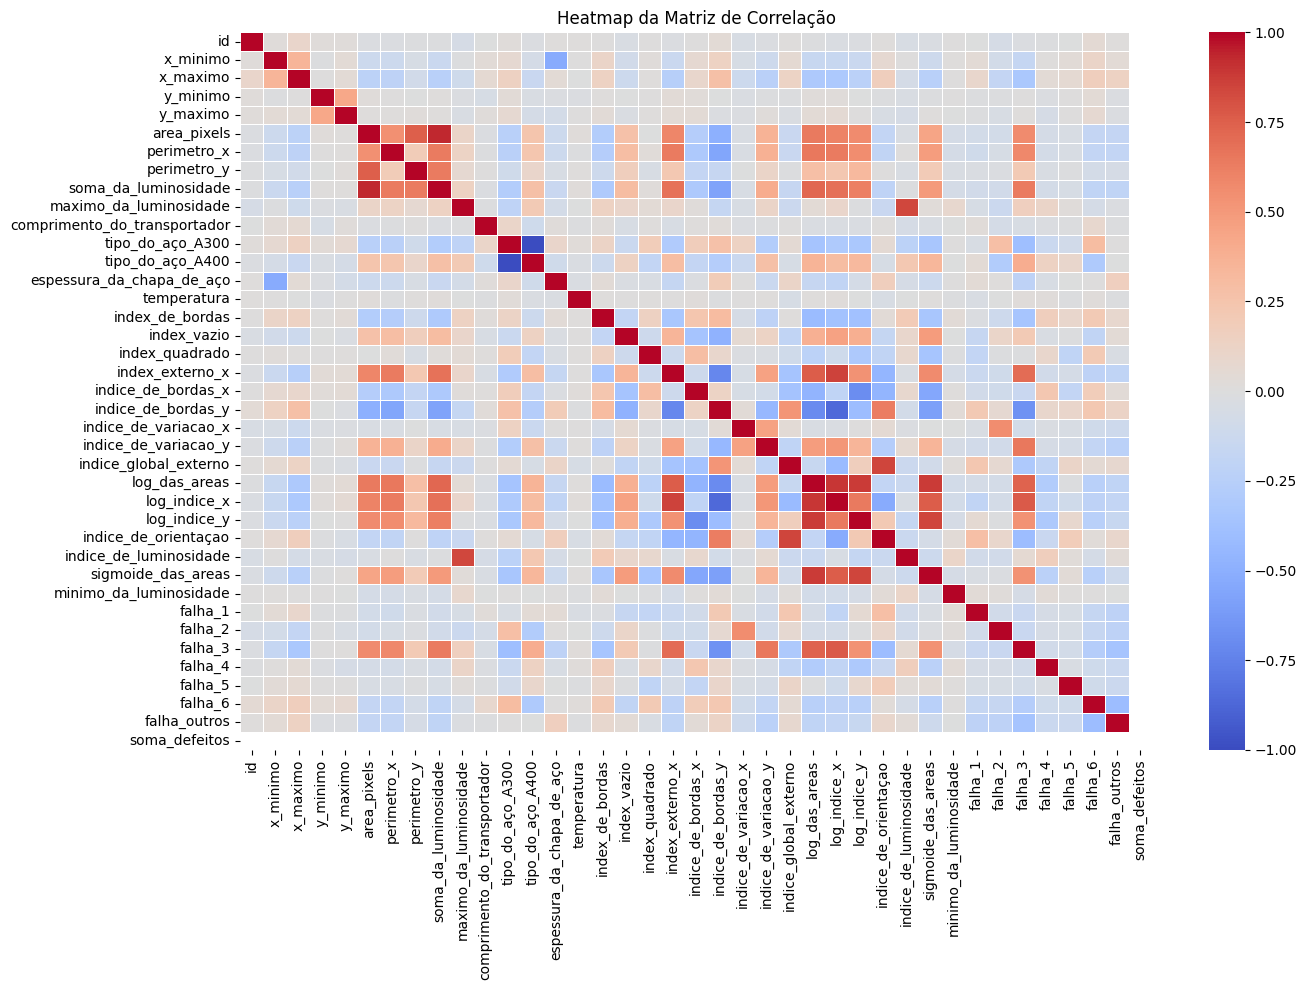

In [113]:
correlacao = df.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(correlacao, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Heatmap da Matriz de Correlação")
plt.tight_layout()
plt.show()
# falha_3, falha_6 e falha_outros apresentam correlações mais visíveis com algumas variáveis como:
# indice_de_luminosidade, indice_de_variacao_y, indice_de_orientacao.
# id tem correlação zero com tudo
# temperatura e espessura_da_chapa_de_aço têm correlação fraca com quase todas as variáveis 

In [114]:
'''
Agrupamentos fortes:
  • Vários índices derivados (como indice_de_bordas_x, indice_global_externo,
  log_das_areas, log_indice_x) estão positivamente correlacionados entre si.

Correlação com as classes de falha:
  As falhas: falha_3, falha_6 e falha_outros apresentam correlações mais visíveis
  com algumas variáveis como:

    • indice_de_luminosidade
    • indice_de_variacao_y
    • indice_de_orientacao

  Me parecem ser bons candidatos para o modelo

Variáveis com correlação muito fraca ou nula
  • Id tem correlação zero com tudo, não deve ser usada no modelo.
  • Temperatura e espessura_da_chapa_de_aço têm correlação fraca com quase todas
  as variáveis.
'''

'\nAgrupamentos fortes:\n  • Vários índices derivados (como indice_de_bordas_x, indice_global_externo,\n  log_das_areas, log_indice_x) estão positivamente correlacionados entre si.\n\nCorrelação com as classes de falha:\n  As falhas: falha_3, falha_6 e falha_outros apresentam correlações mais visíveis\n  com algumas variáveis como:\n\n    • indice_de_luminosidade\n    • indice_de_variacao_y\n    • indice_de_orientacao\n\n  Me parecem ser bons candidatos para o modelo\n\nVariáveis com correlação muito fraca ou nula\n  • Id tem correlação zero com tudo, não deve ser usada no modelo.\n  • Temperatura e espessura_da_chapa_de_aço têm correlação fraca com quase todas\n  as variáveis.\n'

In [115]:
correlacao_alta = correlacao.where(
    (abs(correlacao) > 0.8) & (abs(correlacao) < 1)
).stack().reset_index()
correlacao_alta.columns = ['Variável 1', 'Variável 2', 'Correlação']

correlacao_alta['Pair'] = correlacao_alta.apply(
    lambda row: tuple(sorted([row['Variável 1'], row['Variável 2']])), axis=1
)
correlacao_alta = correlacao_alta.drop_duplicates(subset='Pair').drop(columns='Pair')
display(correlacao_alta)
# Correlações acima de 0.85 indicam que as variáveis estão trazendo a mesma
# informação ao modelo. Mas pretendo manter todas, já que estarei usando um modelo
# de árvore.


,Variável 1,Variável 2,Correlação
0,area_pixels,soma_da_luminosidade,0.932634
2,maximo_da_luminosidade,indice_de_luminosidade,0.837194
3,index_externo_x,log_indice_x,0.852832
4,indice_de_bordas_y,log_indice_x,-0.861182
5,indice_global_externo,indice_de_orientaçao,0.847105
6,log_das_areas,log_indice_x,0.894817
7,log_das_areas,log_indice_y,0.881238
8,log_das_areas,sigmoide_das_areas,0.876283
13,log_indice_y,sigmoide_das_areas,0.847352


##4.3 - Boxplot

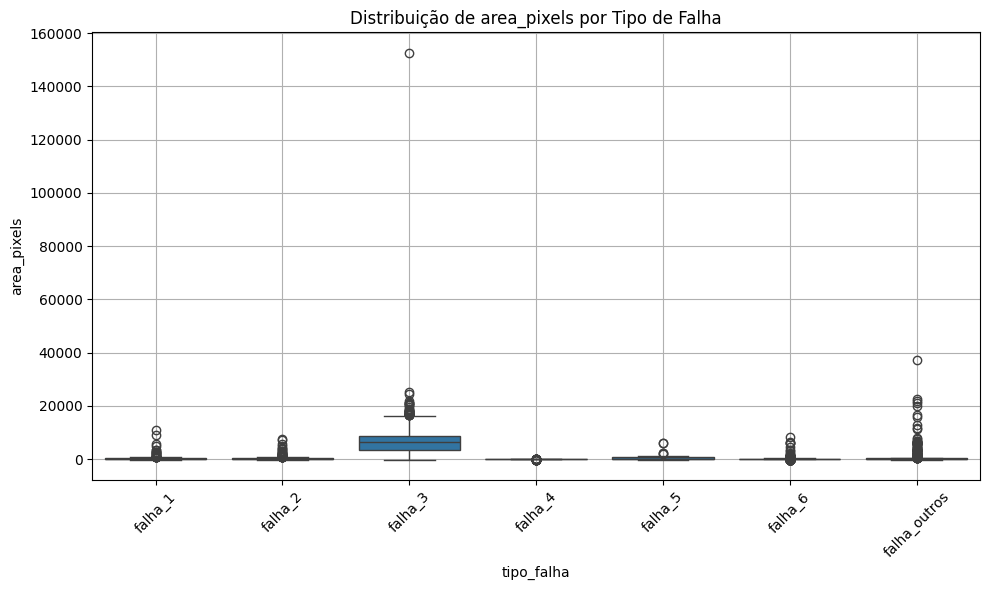

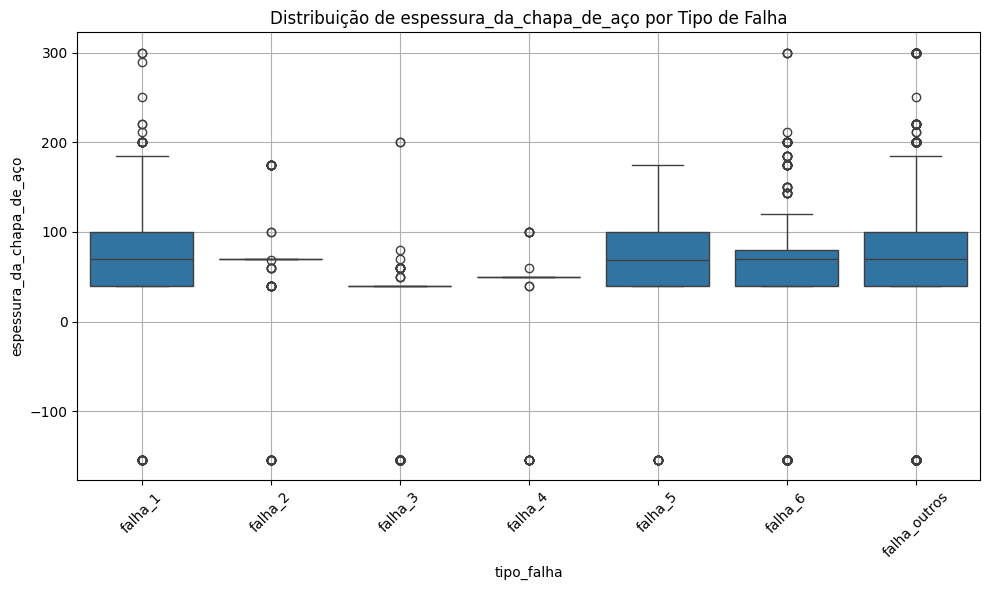

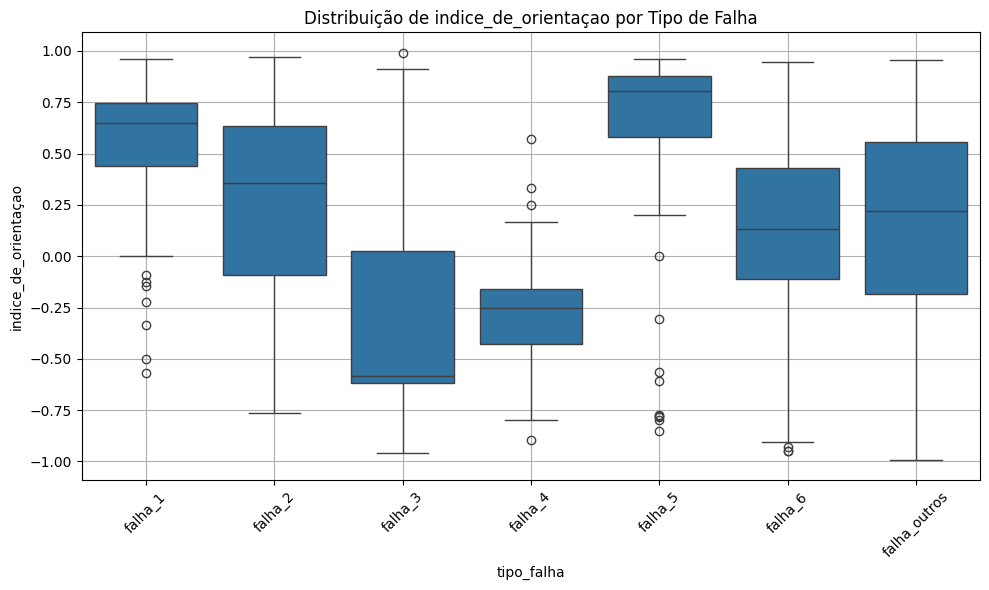

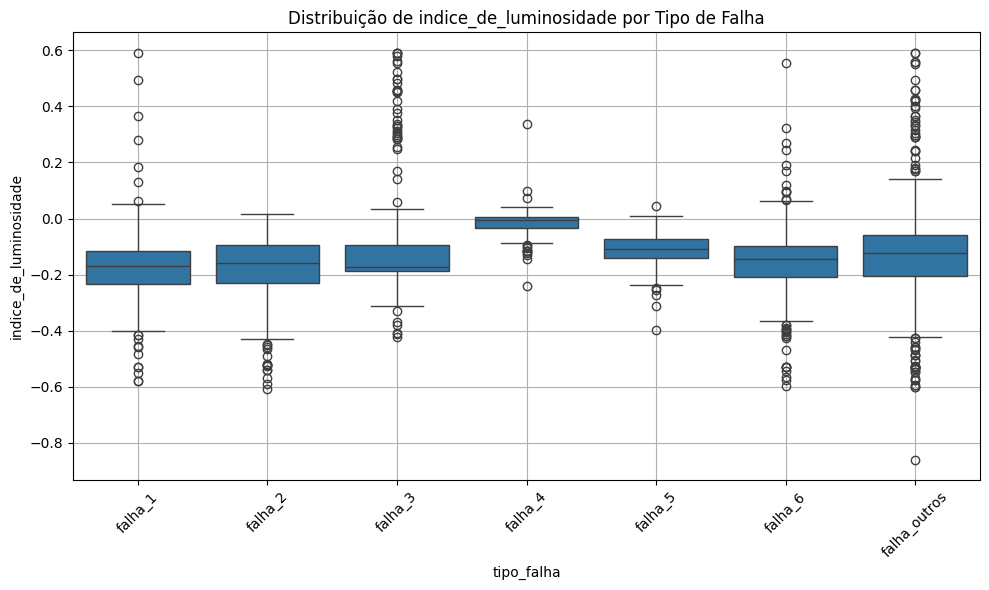

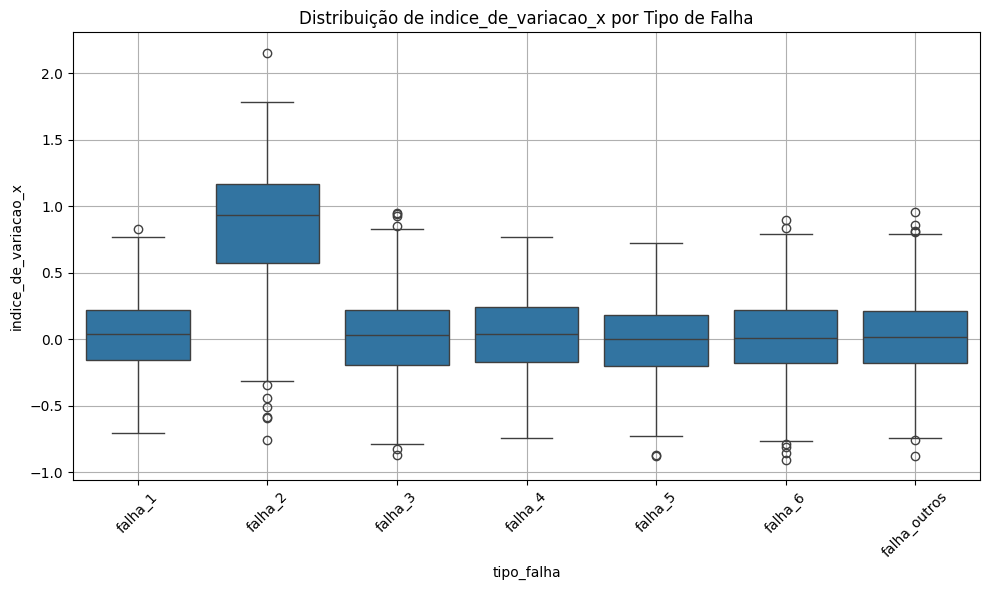

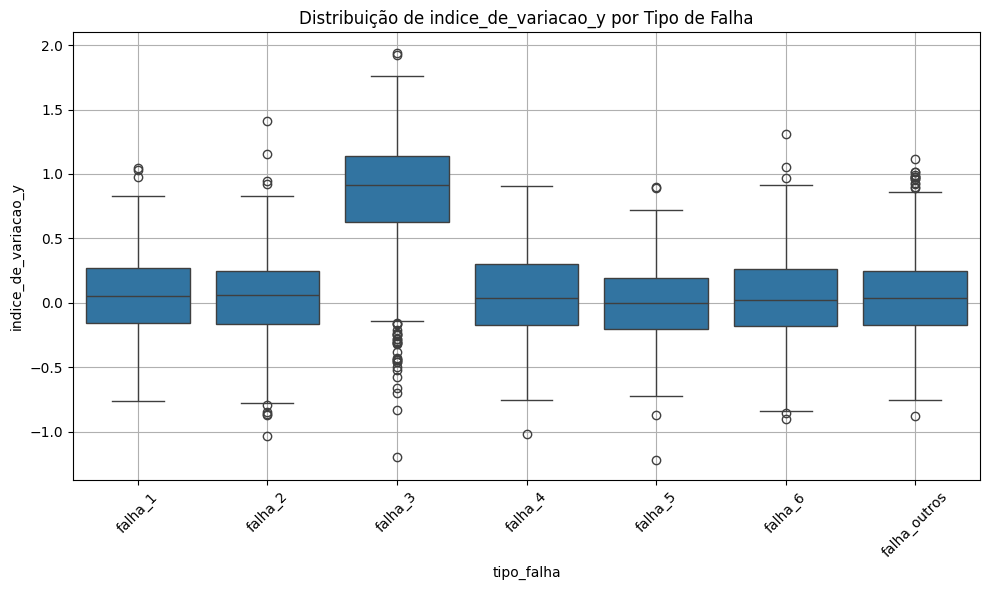

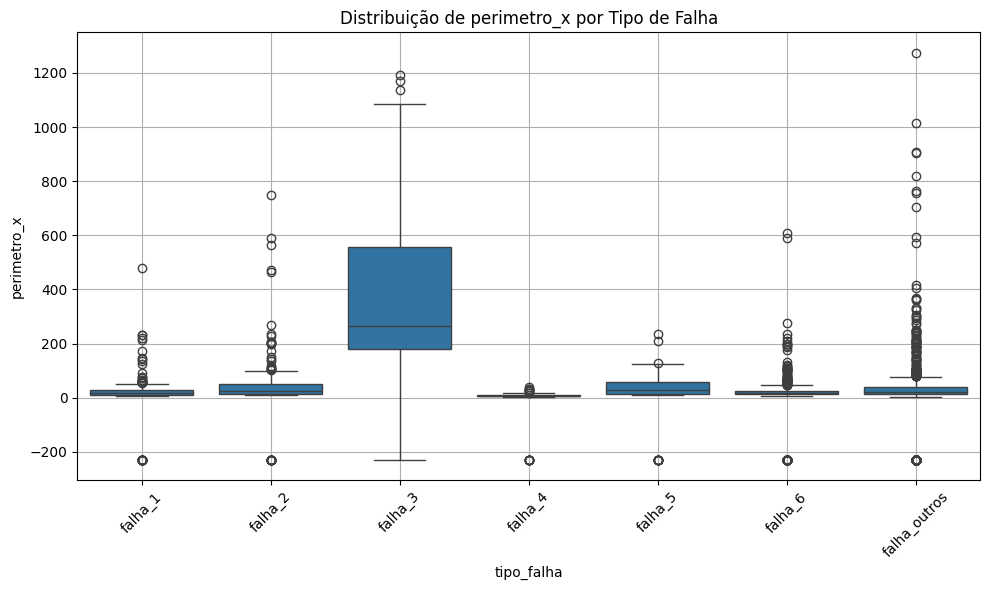

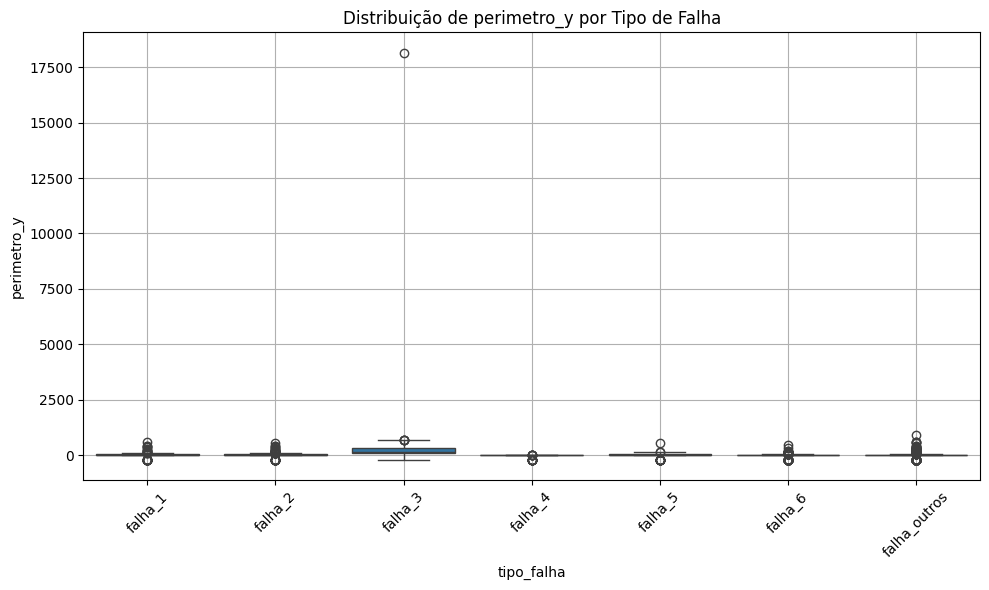

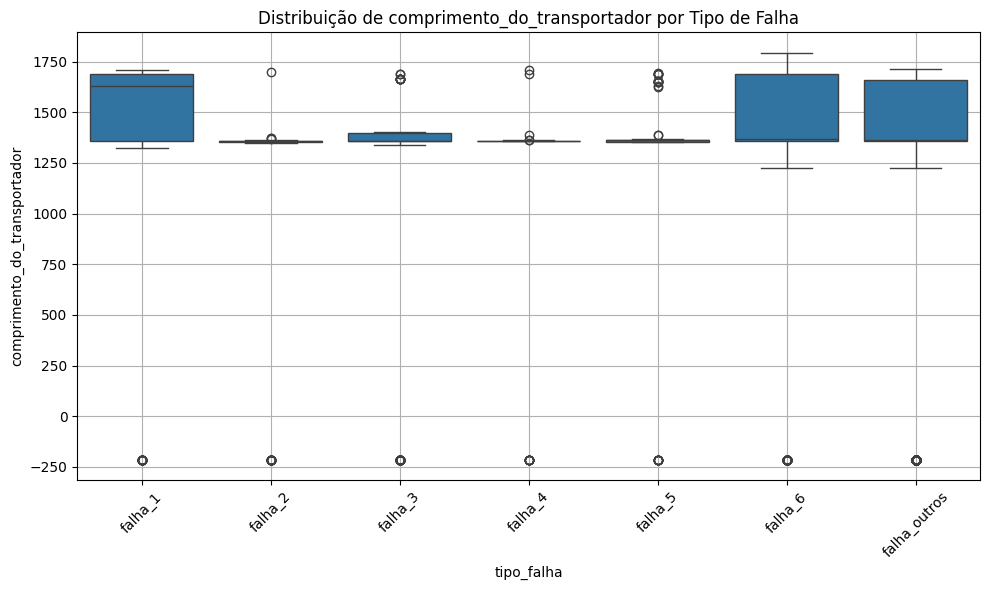

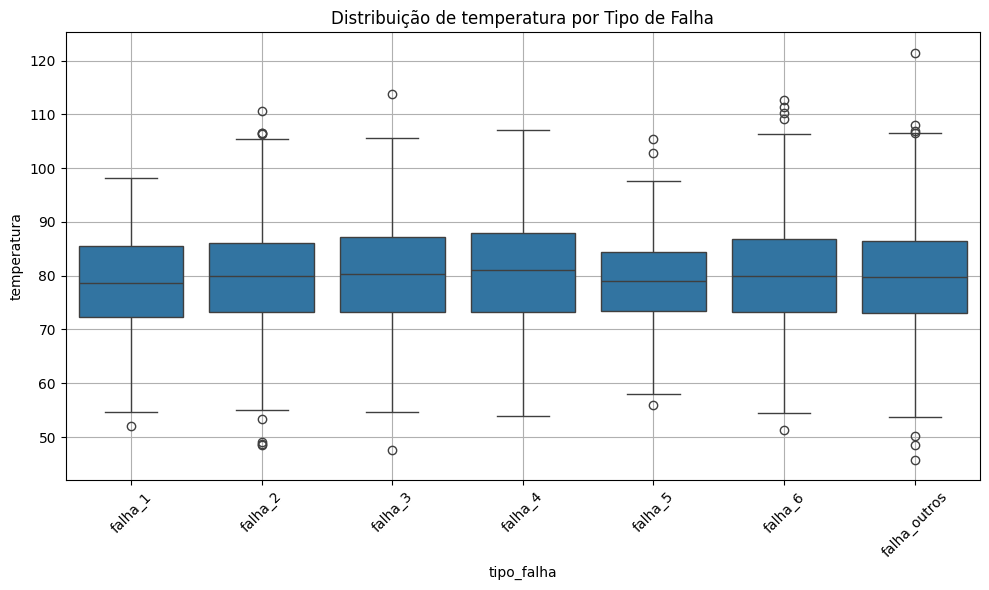

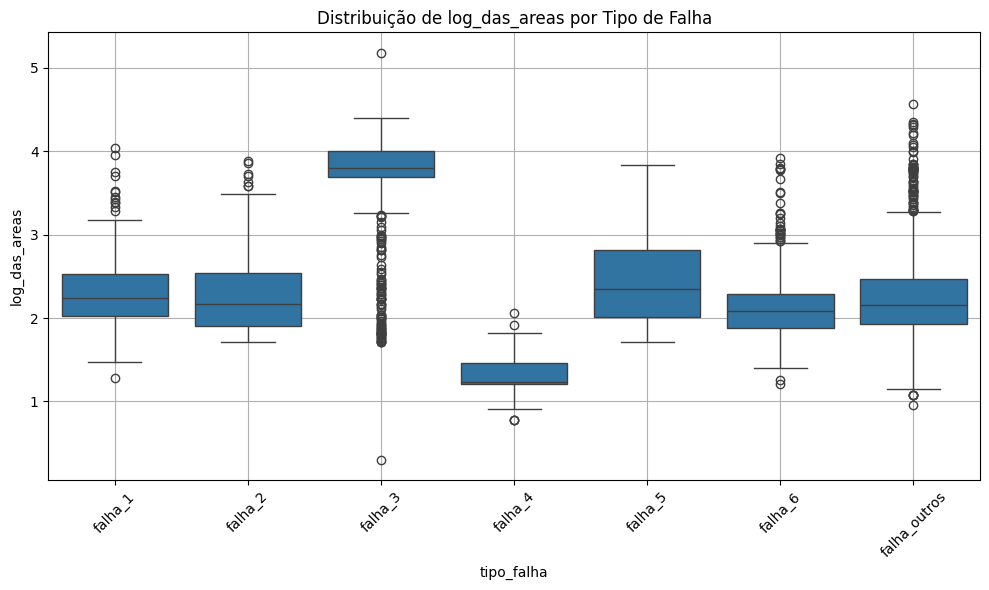

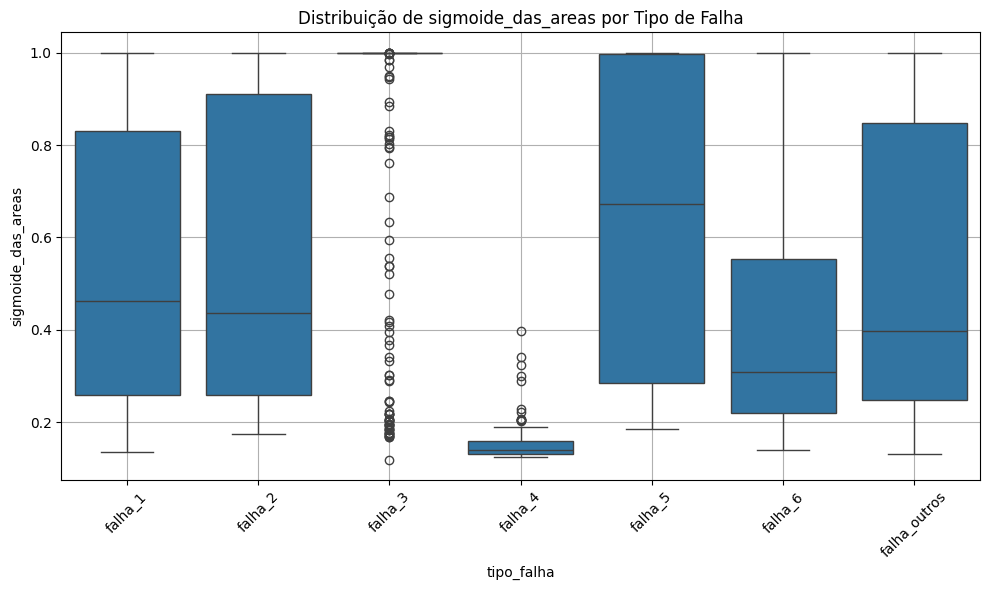

In [116]:
# Variáveis que estarei testando
variaveis_numericas = [
    'area_pixels', 'espessura_da_chapa_de_aço', 'indice_de_orientaçao',
    'indice_de_luminosidade', 'indice_de_variacao_x', 'indice_de_variacao_y',
    'perimetro_x', 'perimetro_y', 'comprimento_do_transportador', 'temperatura',
    'log_das_areas', 'sigmoide_das_areas'
]

# Pegando os meus alvos
colunas_falha = ['falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5', 'falha_6', 'falha_outros']

# Derretendo o df apenas onde tenho falhas
df_derretido = df.melt(id_vars=variaveis_numericas, value_vars=colunas_falha,
                       var_name='tipo_falha', value_name='presenca_falha')

df_filtrado = df_derretido[df_derretido['presenca_falha'] == 1]

# Criando boxplots para cada variável recomendada
for var in variaveis_numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='tipo_falha', y=var, data=df_filtrado)
    plt.title(f'Distribuição de {var} por Tipo de Falha')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [117]:
'''
Indice_de_orientaçao e indice_de_variacao_y mostram distribuições bem distintas
entre tipos de falha, parecem ser bons candidatos como features.

Area_pixels e espessura_da_chapa_de_aço tem boas separações em algumas falhas.

Log_das_areas e sigmoide_das_areas mostram separações claras, principalmente para falha_3 e falha_outros
'''

'\nIndice_de_orientaçao e indice_de_variacao_y mostram distribuições bem distintas\nentre tipos de falha, parecem ser bons candidatos como features.\n\nArea_pixels e espessura_da_chapa_de_aço tem boas separações em algumas falhas.\n\nLog_das_areas e sigmoide_das_areas mostram separações claras, principalmente para falha_3 e falha_outros\n'

## 4.4 - Análise multivariada com PCA

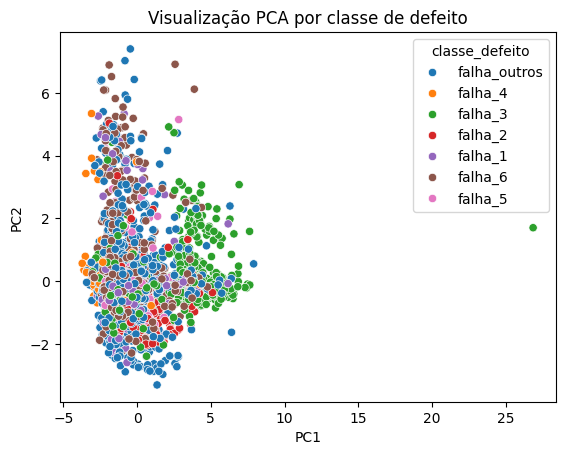

In [118]:
from sklearn.decomposition import PCA # Analise de componentes principais
from sklearn.preprocessing import StandardScaler # Normaliza as variáveis

# Visualizando o conjunto em 2 dimensões, reduzindo a dimensionalidade com PCA

variaveis_numericas = [
    'x_minimo', 'x_maximo', 'y_minimo', 'y_maximo',
    'area_pixels', 'perimetro_x', 'perimetro_y',
    'espessura_da_chapa_de_aço', 'comprimento_do_transportador',
    'temperatura', 'indice_de_orientaçao', 'indice_de_luminosidade',
    'indice_de_variacao_x', 'indice_de_variacao_y',
    'log_das_areas', 'log_indice_x', 'log_indice_y',
    'sigmoide_das_areas'
]

X = df[variaveis_numericas] # Selecionando as variáveis numéricas
X_scaled = StandardScaler().fit_transform(X) # Normalizando os dados (Precisam ter a mesma escala)

pca = PCA(n_components=2) # Reduzindo o espaço dos dados para duas dimensões
X_pca = pca.fit_transform(X_scaled)

# Plotando o gráfico, irei colorir ele de acordo com os defeitos
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['classe_defeito'] = df['classe_defeito']

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='classe_defeito')
plt.title('Visualização PCA por classe de defeito')
plt.show()
# falha_3 (verde) se agrupa mais a direita.
# falha_outros (azul) esta mais dispersa.

## 4.5 Desequilibrio das classes

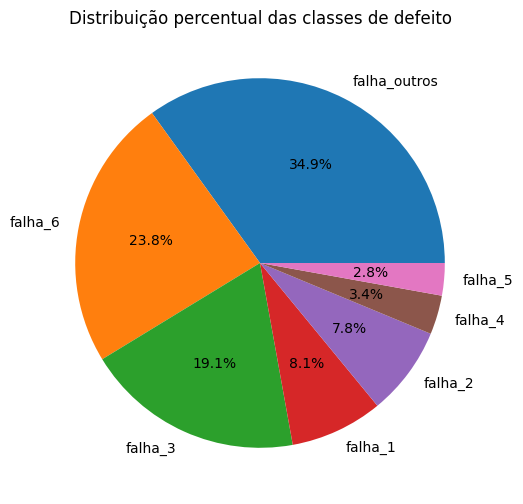

In [119]:
df['classe_defeito'].value_counts(normalize=True).plot.pie(autopct='%.1f%%', figsize=(6, 6))
plt.title('Distribuição percentual das classes de defeito')
plt.ylabel('')
plt.show()
# Vendo o desequilibrio das classes num gráfico de pizza

In [120]:
'''
O dataset está bastante desbalanceado.

Falha_outros, falha_6 e falha_3 representam mais de 75% das amostras.

Falha_4 e Falha_5 são minorias, isso pode prejudicar o desempenho do modelo
nessas classes.
'''

'\nO dataset está bastante desbalanceado.\n\nFalha_outros, falha_6 e falha_3 representam mais de 75% das amostras.\n\nFalha_4 e Falha_5 são minorias, isso pode prejudicar o desempenho do modelo\nnessas classes.\n'

## 4.6 - Análise de correlação entre falhas

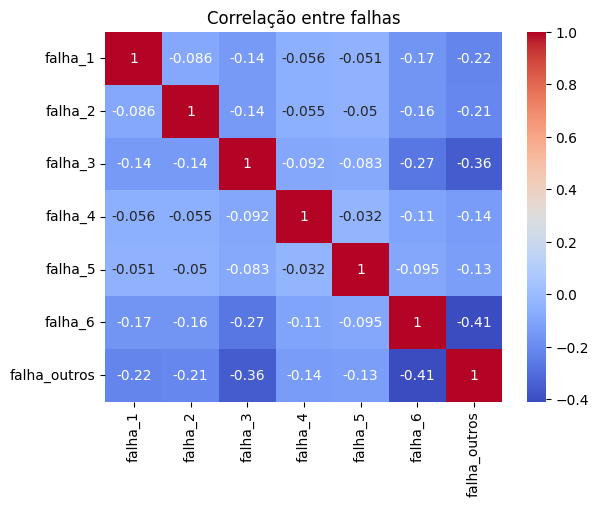

In [121]:
'''
A matriz de correlação entre as variáveis de falha confirmou a exclusividade
entre os rótulos. Todas as correlações foram negativas ou próximas de zero,
o que valida o uso de uma variável única (classe_defeito) como alvo para
modelagem.
'''
sns.heatmap(df[colunas_falha].corr(), annot=True, cmap='coolwarm')
plt.title("Correlação entre falhas")
plt.show()

## 4.7 - Distribuição de variáveis contínuas

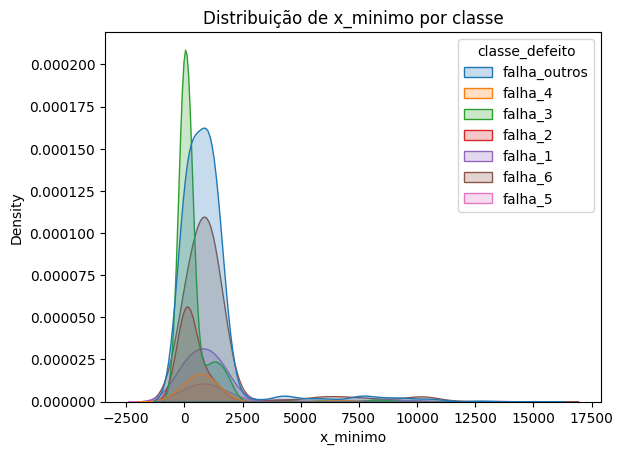

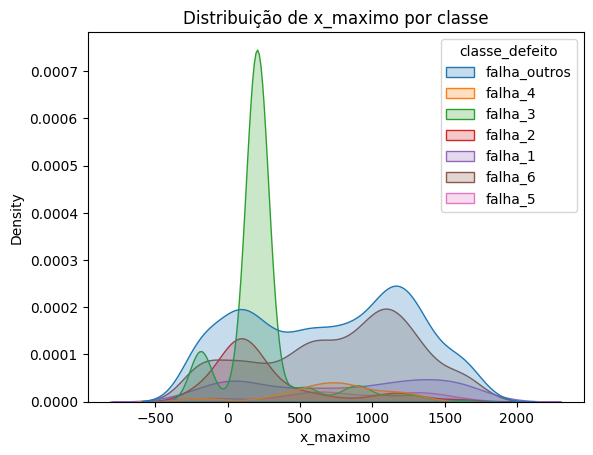

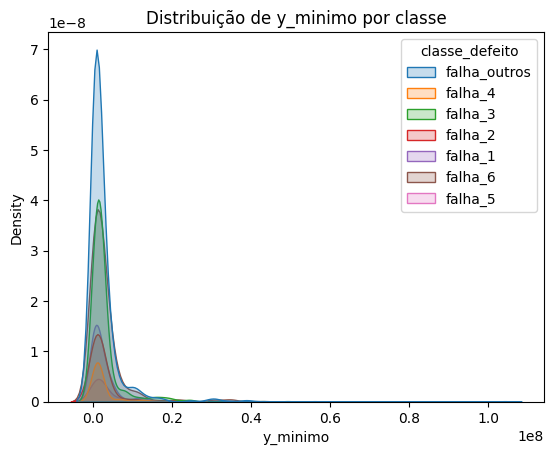

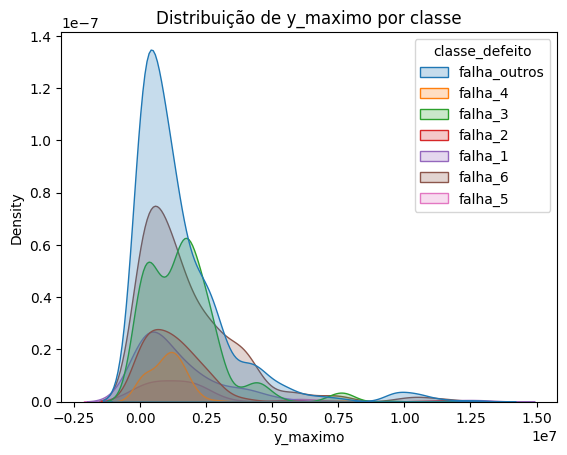

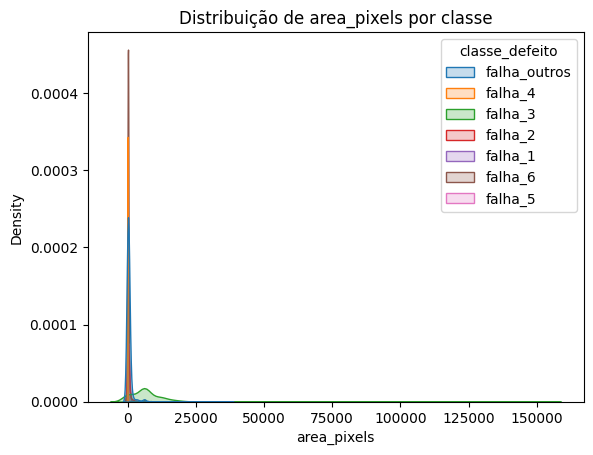

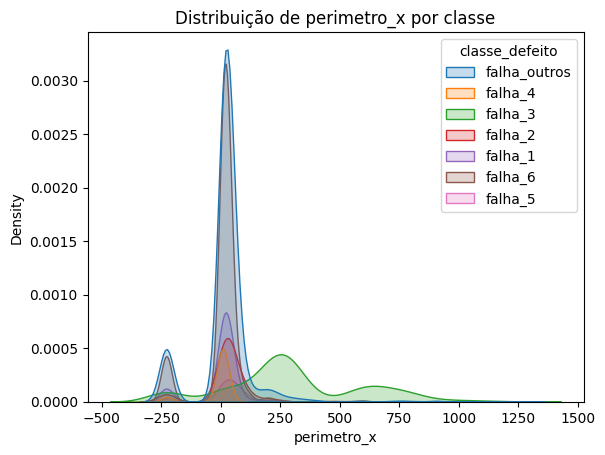

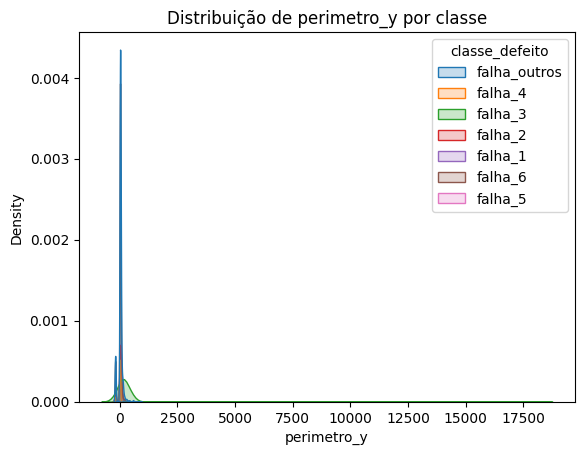

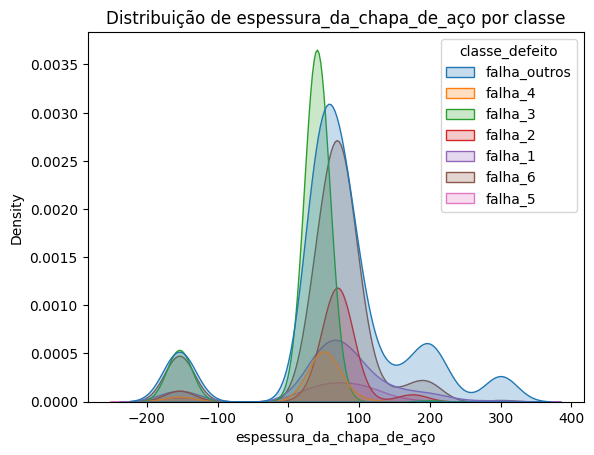

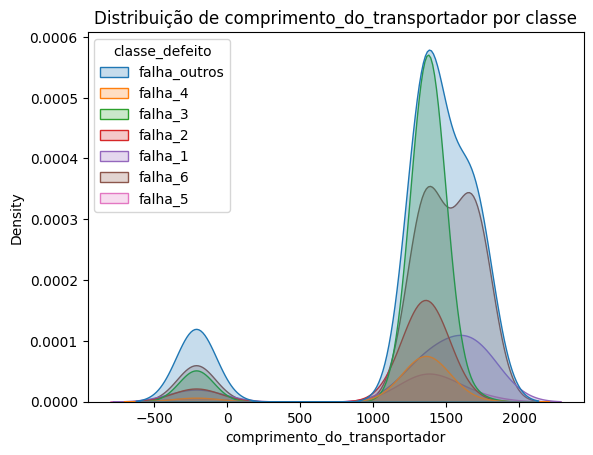

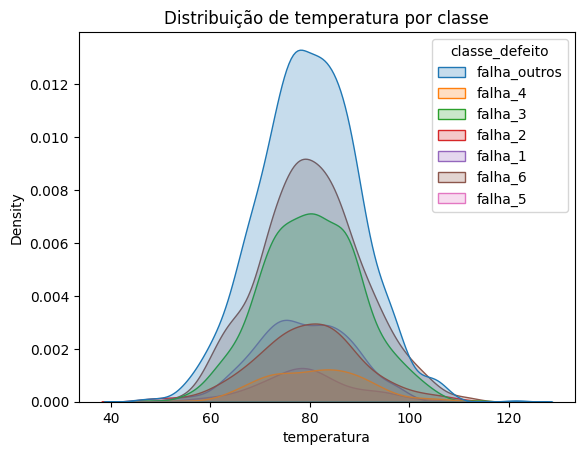

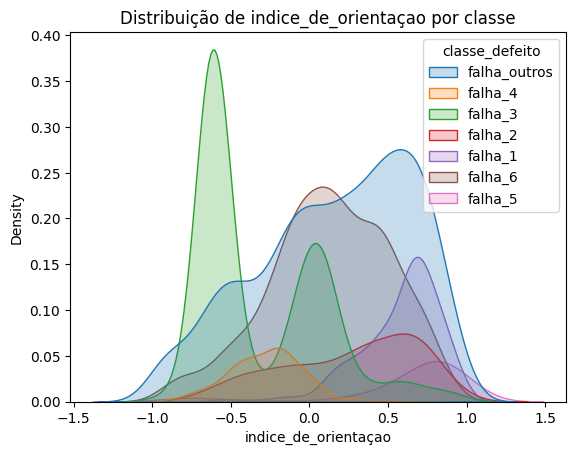

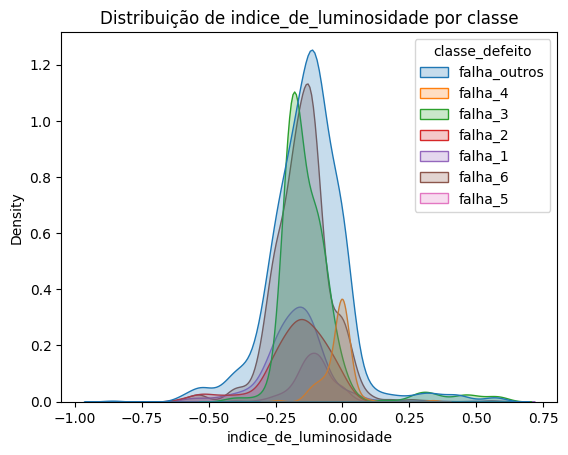

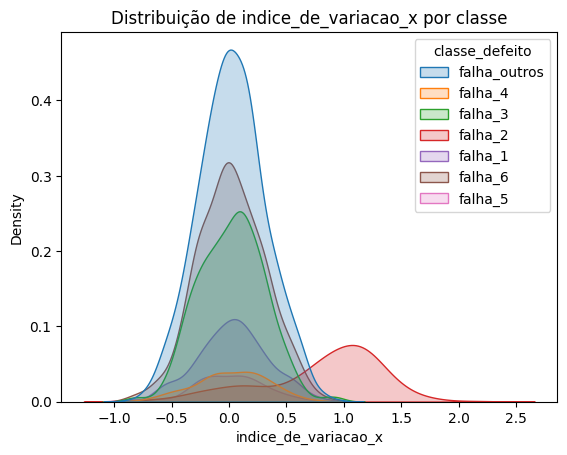

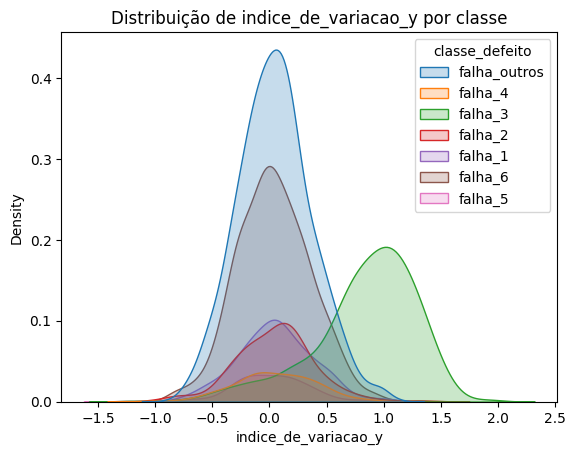

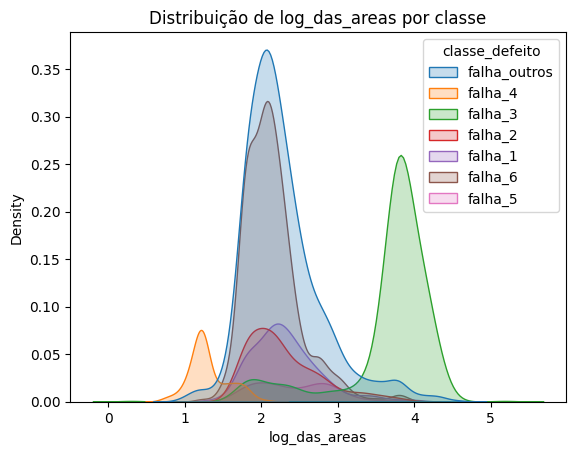

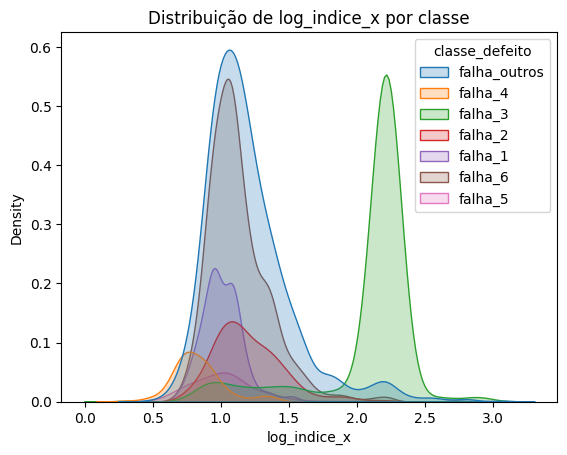

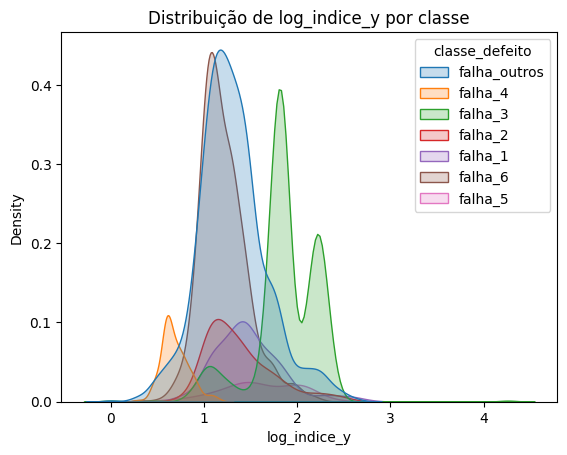

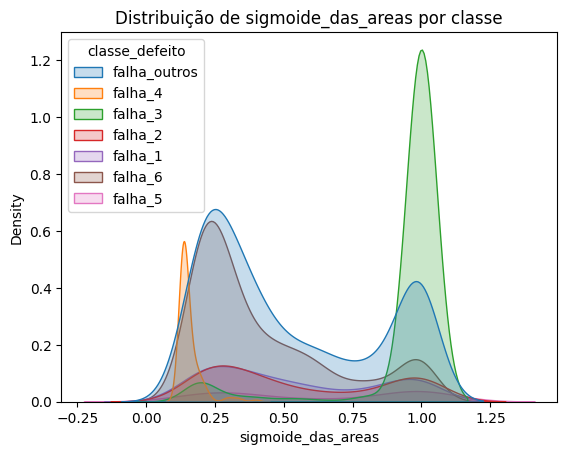

In [122]:
for col in variaveis_numericas:
    sns.kdeplot(data=df, x=col, hue='classe_defeito', fill=True)
    plt.title(f'Distribuição de {col} por classe')
    plt.show()

# Observando como as variáveis se distribuem entre as diferentes classes de falhas.
# Busca por campos que sejam interessantes

# 5 - Baixando o df_final

In [123]:
'''
Convertendo para csv o df_final, a única diferença dele para o que foi utilizado
durante a AED, é que nele não foi realizada nenhuma imputação.
'''
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3389 entries, 0 to 3389
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3389 non-null   int64  
 1   x_minimo                      3389 non-null   int64  
 2   x_maximo                      3333 non-null   float64
 3   y_minimo                      3389 non-null   int64  
 4   y_maximo                      3389 non-null   int64  
 5   area_pixels                   3389 non-null   int64  
 6   perimetro_x                   3389 non-null   int64  
 7   perimetro_y                   3389 non-null   int64  
 8   soma_da_luminosidade          3289 non-null   float64
 9   maximo_da_luminosidade        3291 non-null   float64
 10  comprimento_do_transportador  3389 non-null   int64  
 11  tipo_do_aço_A300              3389 non-null   int64  
 12  tipo_do_aço_A400              3389 non-null   float64
 13  espessur

In [124]:
df_final.isnull().sum() # Verificando os nulos

id                                0
x_minimo                          0
x_maximo                         56
y_minimo                          0
y_maximo                          0
area_pixels                       0
perimetro_x                       0
perimetro_y                       0
soma_da_luminosidade            100
maximo_da_luminosidade           98
comprimento_do_transportador      0
tipo_do_aço_A300                  0
tipo_do_aço_A400                  0
espessura_da_chapa_de_aço        41
temperatura                       0
index_de_bordas                   0
index_vazio                       0
index_quadrado                   36
index_externo_x                   0
indice_de_bordas_x                0
indice_de_bordas_y                0
indice_de_variacao_x              0
indice_de_variacao_y              0
indice_global_externo            59
log_das_areas                     0
log_indice_x                      0
log_indice_y                      0
indice_de_orientaçao        

In [125]:
df_final.to_csv('../outputs/chapa-treino.csv', index=False)